In [1]:
import pandas as pd
import numpy as np
import json
import traceback, sys
import matplotlib.pyplot as plt
import seaborn as sns
# Import display from IPython to display the dataframes
from IPython.display import display

In [2]:
# Adjust the display width for the "Range" column
pd.set_option('display.max_colwidth', 100)  # Set to desired width

In [3]:
BASE_PATH = "/Users/shamweelmohammed/Desktop/Masters/Research/trace/analysis/output/june_7/inference_after_model_load/"

In [4]:
REPORTS_PATH = "/Users/shamweelmohammed/Desktop/Masters/Research/trace/apr19/reports_inference_profile_llama_apr19_3_bsz_1/"

In [5]:
def prepare_data(df, threshold, time_percentage_col, operation_col):
    small_slices = df[df[time_percentage_col] < threshold]
    if not small_slices.empty:
        other_data = pd.DataFrame({time_percentage_col: [small_slices[time_percentage_col].sum()], 
                                   operation_col: ['Others']})
        df = pd.concat([df[df[time_percentage_col] >= threshold], other_data], ignore_index=True)
    return df

In [6]:
def get_others_items(df, threshold, time_percentage_col, operation_col):
    small_slices = df[df[time_percentage_col] < threshold]
    if not small_slices.empty:
        other_items = small_slices[operation_col].tolist()
        return other_items
    else:
        return []

In [7]:
def plot_pie_chart(df, title, threshold, percentage_col, stat_col, stat_base, operation_col, colors, legend_title, plt_title, figsize=(10, 10)):
    # Prepare the data for the pie chart
    df_filtered = prepare_data(df, threshold, percentage_col, operation_col)
    
    # Get the items that are grouped as others
    others_items = get_others_items(df, threshold, percentage_col, operation_col)
    
    # Setup pie chart plot
    plt.figure(figsize=figsize)  # Increase figure size for better readability

    # Plot pie chart without showing percentages on the pie
    # wedges, texts, autotexts = plt.pie(df_filtered[percentage_col],
    #                                    startangle=140, colors=colors, textprops={'fontsize': 12}, autopct='%1.1f%%')
    # wedges, texts = plt.pie(df_filtered[percentage_col], startangle=140, colors=colors, textprops={'fontsize': 12})
    wedges, texts = plt.pie(df_filtered[percentage_col], startangle=140, colors=colors, textprops={'fontsize': 14})

    # Calculate the percentages for the pie chart
    total = sum(df_filtered[percentage_col])
    percentages = [f'{(x/total) * 100:.3f}%' for x in df_filtered[percentage_col]]

    # Round time values to four decimal places and add suffix
    df_filtered["Stat_Col"] = df_filtered[stat_col].apply(lambda x: f'{x:.2f} {stat_base}')

    # Each operation must not be more than 50 characters
    df_filtered[operation_col] = df_filtered[operation_col].apply(lambda x: x[:50] + '...' if len(x) > 50 else x)
    
    # Create custom labels for each slice with times included
    legend_labels = [f'{op} - {perc} ({stat})' for op, perc, stat in zip(df_filtered[operation_col], percentages, df_filtered["Stat_Col"])]
    
    # Adding a legend to handle small slices or clarify the chart
    plt.legend(wedges, legend_labels, title=legend_title, loc="best", fontsize='small')

    # Better title display
    # plt.title(plt_title, fontsize=14, fontweight='bold')
    plt.title(plt_title, fontsize=16, fontweight='bold')
    
    # Show plot with adjustments
    plt.show()
    
    return others_items

In [8]:
def plot_bar_chart(df, title, threshold, percentage_col, stat_col, stat_base, operation_col, x_label, y_label, bar_label, bar_color='b', figsize=(8, 4), legends=True, bar_width = 0.35, xlabel_rotation=25):
    # Prepare the data for the bar chart
    df_bar = df.sort_values(by=percentage_col, ascending=False)
    
    # Set "Others" for items less than threshold
    df_bar = prepare_data(df_bar, threshold, percentage_col, operation_col)
    
    # Get the list of items that are aggregated into 'Others'
    other_items = get_others_items(df, threshold, percentage_col, operation_col)
    
    # Setup bar chart plot
    plt.figure(figsize=figsize)  # Increase figure size for better readability
    
    # Plot bar chart with additional information
    fig, ax = plt.subplots(figsize=figsize)
    
    index = np.arange(len(df_bar))
    
    # Each operation must not be more than 50 characters
    df_bar[operation_col] = df_bar[operation_col].apply(lambda x: x[:50])
    
    # Plot bars
    bar1 = ax.bar(index, df_bar[percentage_col], bar_width, label=bar_label, color=bar_color)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(index)
    ax.set_xticklabels(df_bar[operation_col], rotation=xlabel_rotation)
    
    if legends:
        ax.legend()
        
    # Add data labels
    for i, v in enumerate(df_bar[percentage_col]):
        ax.text(i, v + 0.5, str(round(v, 2)), color='black', ha='center')
        # ax.text(i, v + 0.01, f'{v:.4f}', color='black', ha='center')
        
    plt.grid(True)  # Add grid for better visibility
    plt.tight_layout()  # Adjust layout to not cut off labels
    plt.show()
    
    return other_items

In [9]:
def plot_time(df, title, limit, time_col, name_col, label_col, x_label, y_label, legend_label, bar_color='b', figsize=(12, 6), legends = False, bar_width = 0.35, xlabel_rotation=45):
    # Prepare the data for the bar chart
    df_sorted = df.sort_values(by=time_col, ascending=False).head(limit)
    
    # Setup bar chart plot
    plt.figure(figsize=figsize)  # Increase figure size for better readability
    
    bar_width = 0.35  # Increase bar width for better visibility
    index = np.arange(len(df_sorted))
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot bars
    bars = ax.bar(index, df_sorted[time_col], bar_width, label=legend_label, color=bar_color)
    
    # ax.set_xlabel(x_label, fontsize=14)
    # ax.set_ylabel(y_label, fontsize=14)
    # ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    ax.set_title(title, fontsize=18)
    
    ax.set_xticks(index)
    # ax.set_xticklabels(df_sorted[name_col], rotation=xlabel_rotation, fontsize=12)  # Use operation names as labels
    ax.set_xticklabels(df_sorted[name_col], rotation=xlabel_rotation, fontsize=14)  # Use operation names as labels
    
    if legends:
        # ax.legend(fontsize=12)
        ax.legend(fontsize=14)
    
    # Add data labels from label_col
    for bar in bars:
        yval = bar.get_height()
        # ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02*max(df_sorted[time_col]), f'{yval:.2f}', ha='center', va='bottom', fontsize=10)
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02*max(df_sorted[time_col]), f'{yval:.2f}', ha='center', va='bottom', fontsize=14)
        
    plt.grid(True)  # Add grid
    plt.tight_layout()  # Adjust layout to not cut off labels
    plt.show()

# CUDA API Summary

In [10]:
cupa_api_summary_csv_path = BASE_PATH + "cuda_api_summary.csv"
df_cupa_api_summary = pd.read_csv(cupa_api_summary_csv_path)

In [11]:
df_cupa_api_summary

,Time (%),Total Time (ns),Instances,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),Operation,Category
0,85.189975,2958987331,165768,1.785017e+04,11920.0,5020,310883463,1.092566e+06,cudaLaunchKernel,CUDA_API
1,10.086796,350354632,10,3.503546e+07,313398.0,10190,174321091,7.340999e+07,cudaMalloc,MEMORY_OPER
2,3.357801,116629802,8840,1.319342e+04,13640.0,9310,55629,3.659817e+03,cudaMemcpyAsync,MEMORY_OPER
3,0.742222,25780318,4,6.445080e+06,6445109.5,1997349,10892750,5.135537e+06,cudaFree,MEMORY_OPER
4,0.359521,12487581,1,1.248758e+07,12487581.0,12487581,12487581,NaN,cudaProfilerStop,CUDA_API
5,0.178514,6200516,768,8.073589e+03,6350.0,4910,22810,3.403260e+03,cudaMemsetAsync,CUDA_API
6,0.062390,2167036,390,5.556503e+03,4745.0,3580,18850,1.909003e+03,cudaStreamSynchronize,CUDA_API
7,0.011601,402959,233,1.729438e+03,1640.0,520,15450,9.995833e+02,cudaOccupancyMaxActiveBlocksPerMultiprocessor,CUDA_API
8,0.006063,210578,766,2.749060e+02,250.0,140,1760,1.385919e+02,cuGetProcAddress_v2,CUDA_API
9,0.003267,113469,66,1.719227e+03,1710.0,1140,3660,4.017424e+02,cudaStreamIsCapturing_v10000,CUDA_API


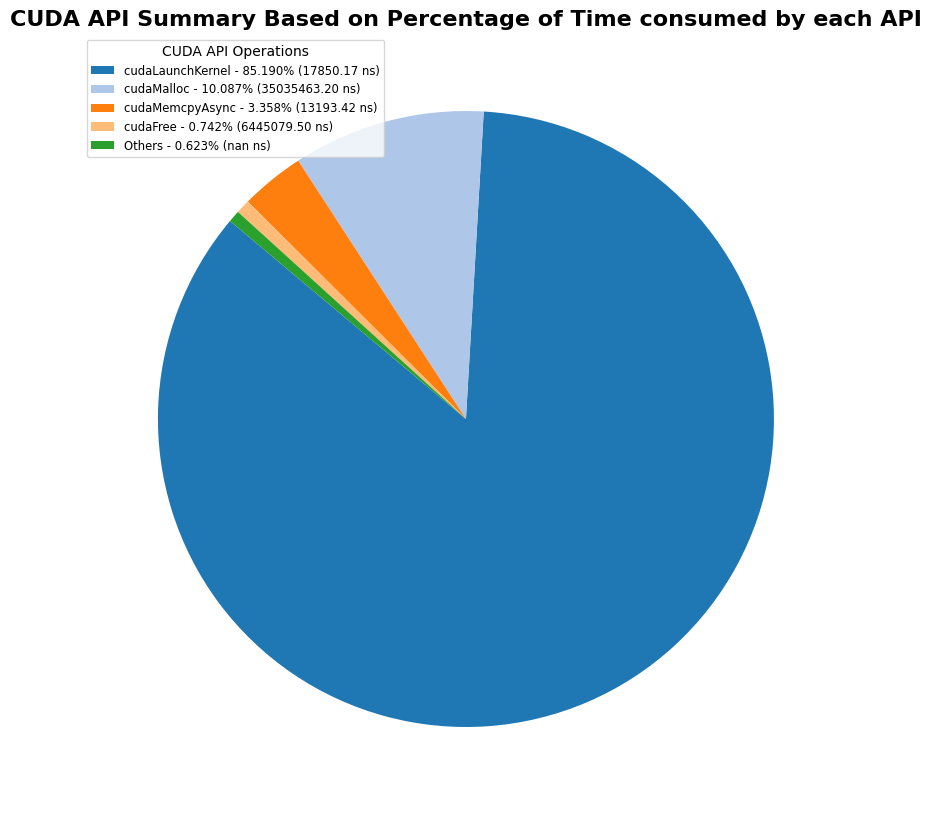

['cudaProfilerStop',
 'cudaMemsetAsync',
 'cudaStreamSynchronize',
 'cudaOccupancyMaxActiveBlocksPerMultiprocessor',
 'cuGetProcAddress_v2',
 'cudaStreamIsCapturing_v10000',
 'cudaEventCreateWithFlags',
 'cudaDeviceSynchronize',
 'cuInit',
 'cuModuleGetLoadingMode']

In [12]:
others_items = plot_pie_chart(df = df_cupa_api_summary,
                title = "CUDA API Summary Based on Percentage of Time consumed by each API",
                threshold = 0.5,
                percentage_col = 'Time (%)',
                stat_col = 'Avg (ns)',
                stat_base = 'ns',
                legend_title = "CUDA API Operations",
                operation_col = "Operation",
                # colors = sns.color_palette("hsv", len(df_cupa_api_summary)),
                colors = sns.color_palette("tab20", len(df_cupa_api_summary)),
                plt_title = "CUDA API Summary Based on Percentage of Time consumed by each API",
                figsize = (10, 10))

others_items

<Figure size 800x400 with 0 Axes>

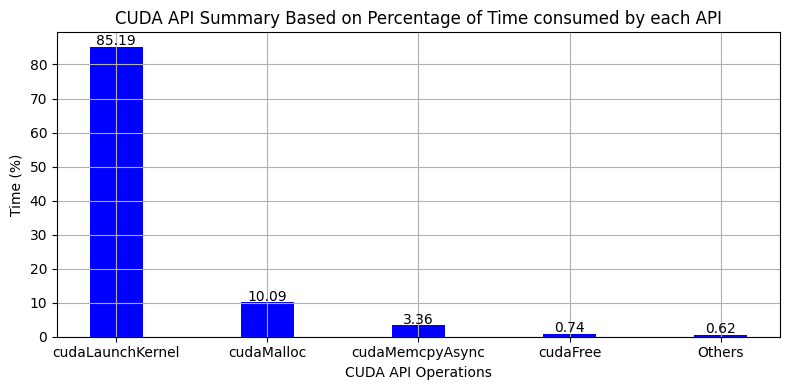

['cudaProfilerStop',
 'cudaMemsetAsync',
 'cudaStreamSynchronize',
 'cudaOccupancyMaxActiveBlocksPerMultiprocessor',
 'cuGetProcAddress_v2',
 'cudaStreamIsCapturing_v10000',
 'cudaEventCreateWithFlags',
 'cudaDeviceSynchronize',
 'cuInit',
 'cuModuleGetLoadingMode']

In [13]:
other_items = plot_bar_chart(df = df_cupa_api_summary,
                title = "CUDA API Summary Based on Percentage of Time consumed by each API",
                threshold = 0.5,
                percentage_col = 'Time (%)',
                stat_col = 'Avg (ns)',
                stat_base = 'ns',
                operation_col = "Operation",
                x_label = "CUDA API Operations",
                y_label = "Time (%)",
                bar_label = "Time (%)",
                bar_color = 'b',
                figsize = (8, 4),
                legends = False,
                bar_width = 0.35,
                xlabel_rotation = 0)
other_items

<Figure size 1200x1000 with 0 Axes>

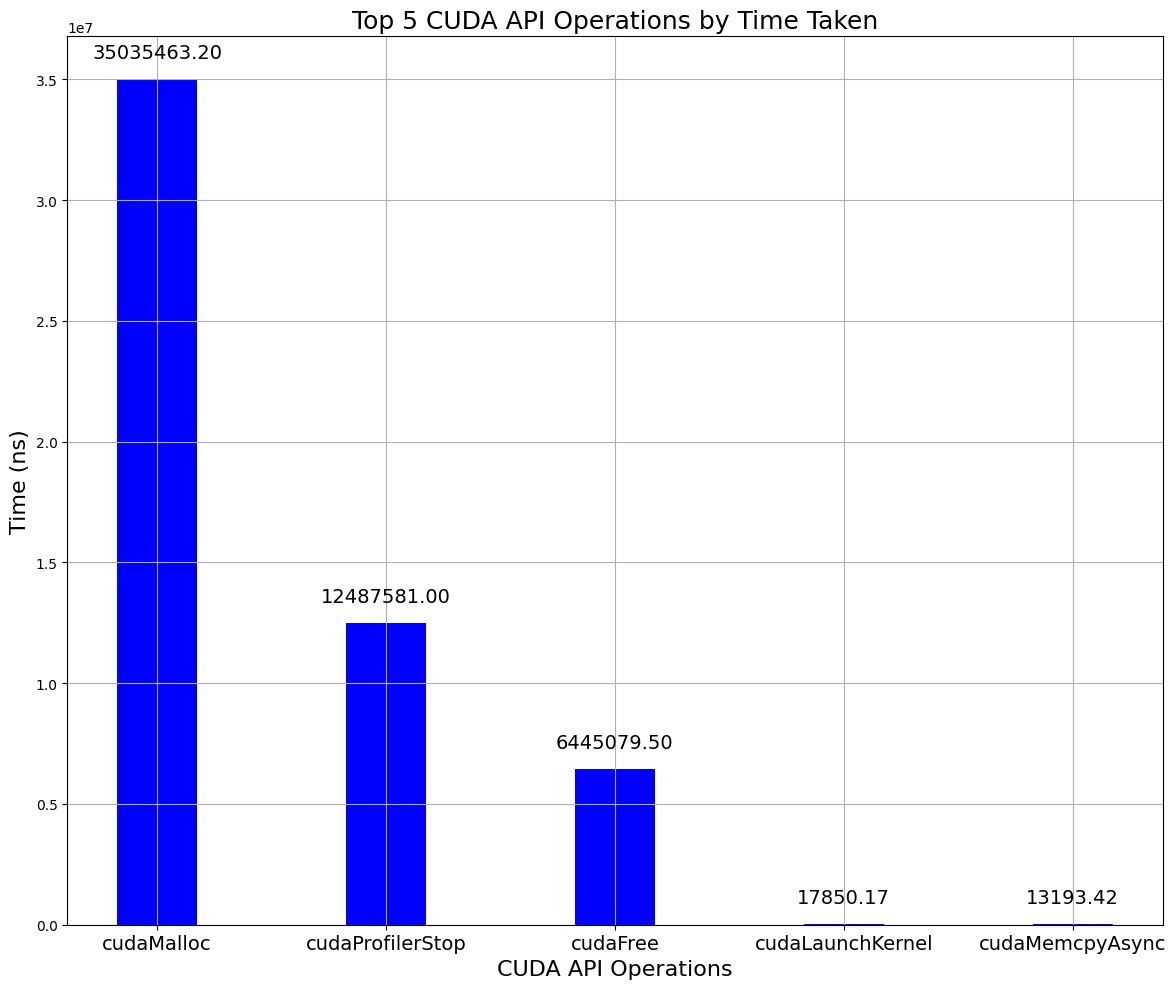

In [14]:
# Plot the top 5 CUDA API operations by time taken ('Avg (ns)')
plot_time(df = df_cupa_api_summary,
            title = "Top 5 CUDA API Operations by Time Taken",
            limit = 5,
            time_col = 'Avg (ns)',
            name_col = 'Operation',
            label_col = 'Avg (ns)',
            x_label = "CUDA API Operations",
            y_label = "Time (ns)",
            legend_label = "Avg Time (ns)",
            bar_color = 'b',
            figsize = (12, 10),
            legends = False,
            bar_width = 0.35,
            xlabel_rotation = 0)

In [15]:
cuda_api_trace_filtered_csv_path = BASE_PATH + "cuda_api_trace_filtered.csv"
df_cuda_api_trace_filtered = pd.read_csv(cuda_api_trace_filtered_csv_path)

In [16]:
df_cuda_api_trace_filtered

,Start (ns),Duration (ns),Name,Result,CorrID,Pid,Tid,T-Pri,Thread Name
0,16043428270,103729,cudaLaunchKernel,0,7396,734,734,20,python
1,16043428420,103139,cudaLaunchKernel,0,7396,734,734,20,python
2,16043947247,18690,cudaMemcpyAsync,0,7410,734,734,20,python
3,16043947327,18520,cudaMemcpyAsync,0,7410,734,734,20,python
4,16044087556,11150,cudaStreamSynchronize,0,7411,734,734,20,python
...,...,...,...,...,...,...,...,...,...
176865,67363811896,3800,cudaStreamSynchronize,0,1075793,734,734,20,python
176866,67363812036,3580,cudaStreamSynchronize,0,1075793,734,734,20,python
176867,67363992815,12210,cudaDeviceSynchronize,0,1075798,734,734,20,python
176868,67363992895,12040,cudaDeviceSynchronize,0,1075798,734,734,20,python


# Malloc and Free

In [17]:
# Get all instances of "cudaMalloc" operations
df_cuda_malloc = df_cuda_api_trace_filtered[df_cuda_api_trace_filtered['Name'] == 'cudaMalloc']
df_cuda_malloc

,Start (ns),Duration (ns),Name,Result,CorrID,Pid,Tid,T-Pri,Thread Name
812,16449746762,174321091,cudaMalloc,0,8644,734,734,20,python
813,16449746882,174320751,cudaMalloc,0,8644,734,734,20,python
822,16624178023,10330,cudaMalloc,0,8653,734,734,20,python
823,16624178103,10190,cudaMalloc,0,8653,734,734,20,python
832,16624244302,188019,cudaMalloc,0,8662,734,734,20,python
833,16624244392,187839,cudaMalloc,0,8662,734,734,20,python
837,16624523661,313488,cudaMalloc,0,8671,734,734,20,python
838,16624523741,313308,cudaMalloc,0,8671,734,734,20,python
3823,17556112485,344898,cudaMalloc,0,26287,734,734,20,python
3824,17556112575,344718,cudaMalloc,0,26287,734,734,20,python


In [18]:
# Total duration of cudaMalloc calls
total_duration = df_cuda_malloc["Duration (ns)"].sum()

# Average duration of cudaMalloc calls
average_duration = df_cuda_malloc["Duration (ns)"].mean()

# Total number of cudaMalloc calls
total_calls = df_cuda_malloc.shape[0]

print(f"Total Duration of cudaMalloc calls: {total_duration} ns")
print(f"Average Duration of cudaMalloc calls: {average_duration} ns")
print(f"Total Number of cudaMalloc calls: {total_calls}")

Total Duration of cudaMalloc calls: 350354632 ns
Average Duration of cudaMalloc calls: 35035463.2 ns
Total Number of cudaMalloc calls: 10


In [19]:
# Get all instances of "cudaFree" operations
df_cuda_free = df_cuda_api_trace_filtered[df_cuda_api_trace_filtered['Name'] == 'cudaFree']
df_cuda_free

,Start (ns),Duration (ns),Name,Result,CorrID,Pid,Tid,T-Pri,Thread Name
423,16433689171,1997799,cudaFree,0,8121,734,734,20,python
424,16433689451,1997349,cudaFree,0,8121,734,734,20,python
810,16438526144,10892750,cudaFree,0,8626,734,734,20,python
811,16438526284,10892420,cudaFree,0,8626,734,734,20,python


In [20]:
# Total duration of cudaFree calls
total_duration = df_cuda_free["Duration (ns)"].sum()

# Average duration of cudaFree calls
average_duration = df_cuda_free["Duration (ns)"].mean()

# Total number of cudaFree calls
total_calls = df_cuda_free.shape[0]

print(f"Total Duration of cudaFree calls: {total_duration} ns")
print(f"Average Duration of cudaFree calls: {average_duration} ns")
print(f"Total Number of cudaFree calls: {total_calls}")

Total Duration of cudaFree calls: 25780318 ns
Average Duration of cudaFree calls: 6445079.5 ns
Total Number of cudaFree calls: 4


# CUDA Memtime Summary

In [21]:
cuda_memtime_summary_csv_path = BASE_PATH + "cuda_memtime_summary.csv"
df_cuda_memtime_summary = pd.read_csv(cuda_memtime_summary_csv_path)

In [22]:
df_cuda_memtime_summary

,Operation,Total Time (ns),Count,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),Time (%)
0,[CUDA memcpy Device-to-Device],14868484,4225,3519.167811,3520.0,3200,4224,101.467665,89.358284
1,[CUDA memcpy Device-to-Host],492035,193,2549.404145,2496.0,2400,5631,248.279795,2.957087
2,[CUDA memcpy Host-to-Device],4000,2,2000.000000,2000.0,1920,2080,113.137085,0.024040
3,[CUDA memset],1274659,384,3319.424479,3616.0,1825,3744,641.704901,7.660589


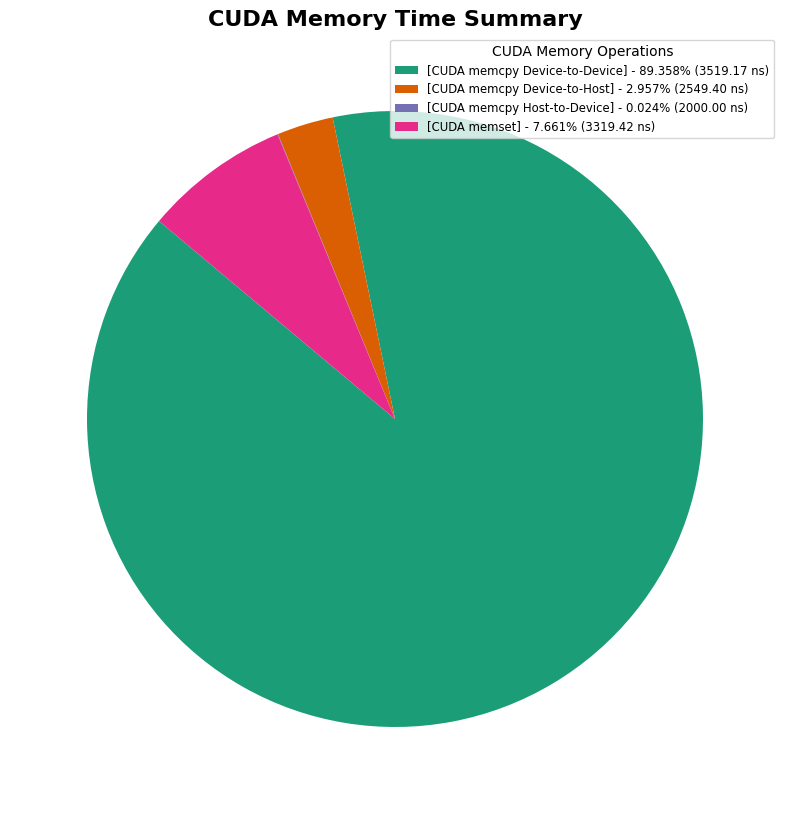

[]

In [23]:
other_items = plot_pie_chart(df = df_cuda_memtime_summary,
                title = "CUDA Memory Time Summary",
                threshold = 0.000,
                percentage_col = 'Time (%)',
                stat_col = 'Avg (ns)',
                stat_base = 'ns',
                legend_title = "CUDA Memory Operations",
                operation_col = "Operation",
                # Color with brown color palette other than tab20
                colors = sns.color_palette("Dark2", len(df_cuda_memtime_summary)),
                plt_title = "CUDA Memory Time Summary",
                figsize = (10, 10))

other_items

<Figure size 1000x1000 with 0 Axes>

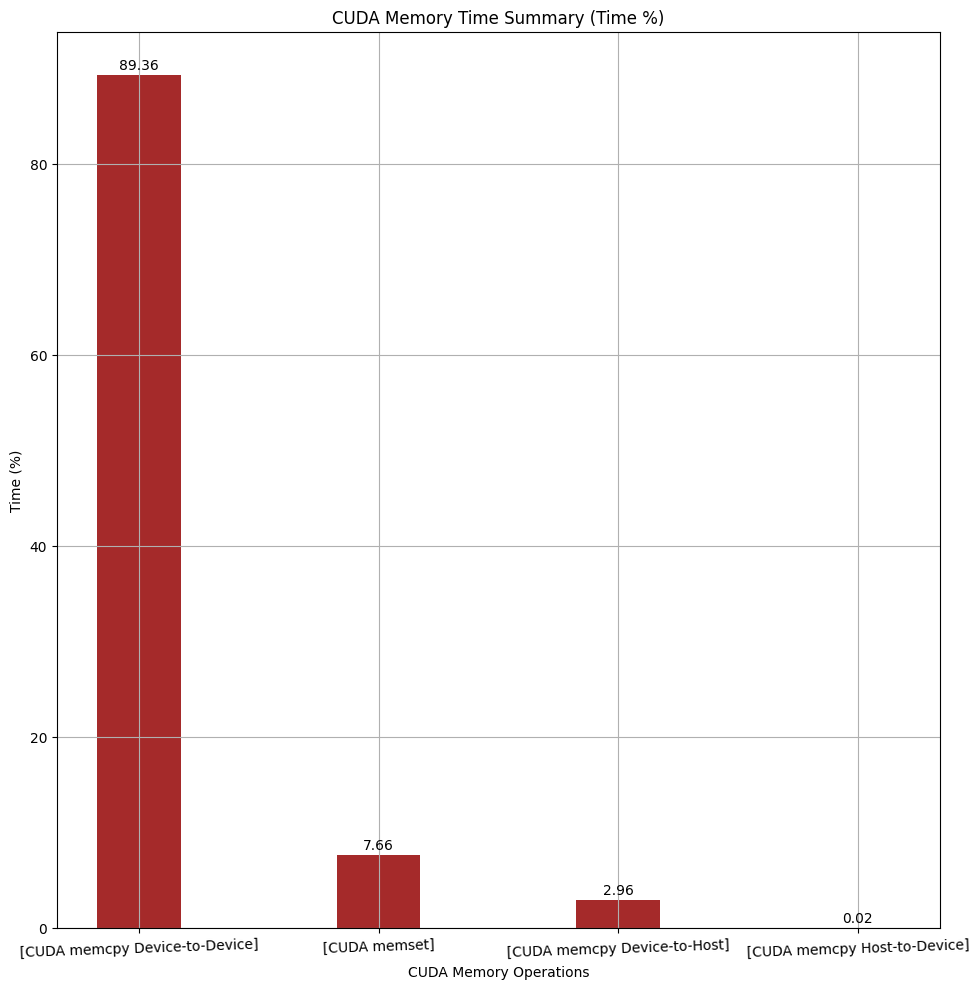

[]

In [24]:
other_items = plot_bar_chart(df = df_cuda_memtime_summary,
                title = "CUDA Memory Time Summary (Time %)",
                threshold = 0.0000,
                percentage_col = 'Time (%)',
                stat_col = 'Avg (ns)',
                stat_base = 'ns',
                operation_col = "Operation",
                x_label = "CUDA Memory Operations",
                y_label = "Time (%)",
                bar_label = "Time (%)",
                bar_color = 'brown',
                figsize = (10, 10),
                legends = False,
                bar_width = 0.35,
                xlabel_rotation = 2)

other_items

<Figure size 1200x1000 with 0 Axes>

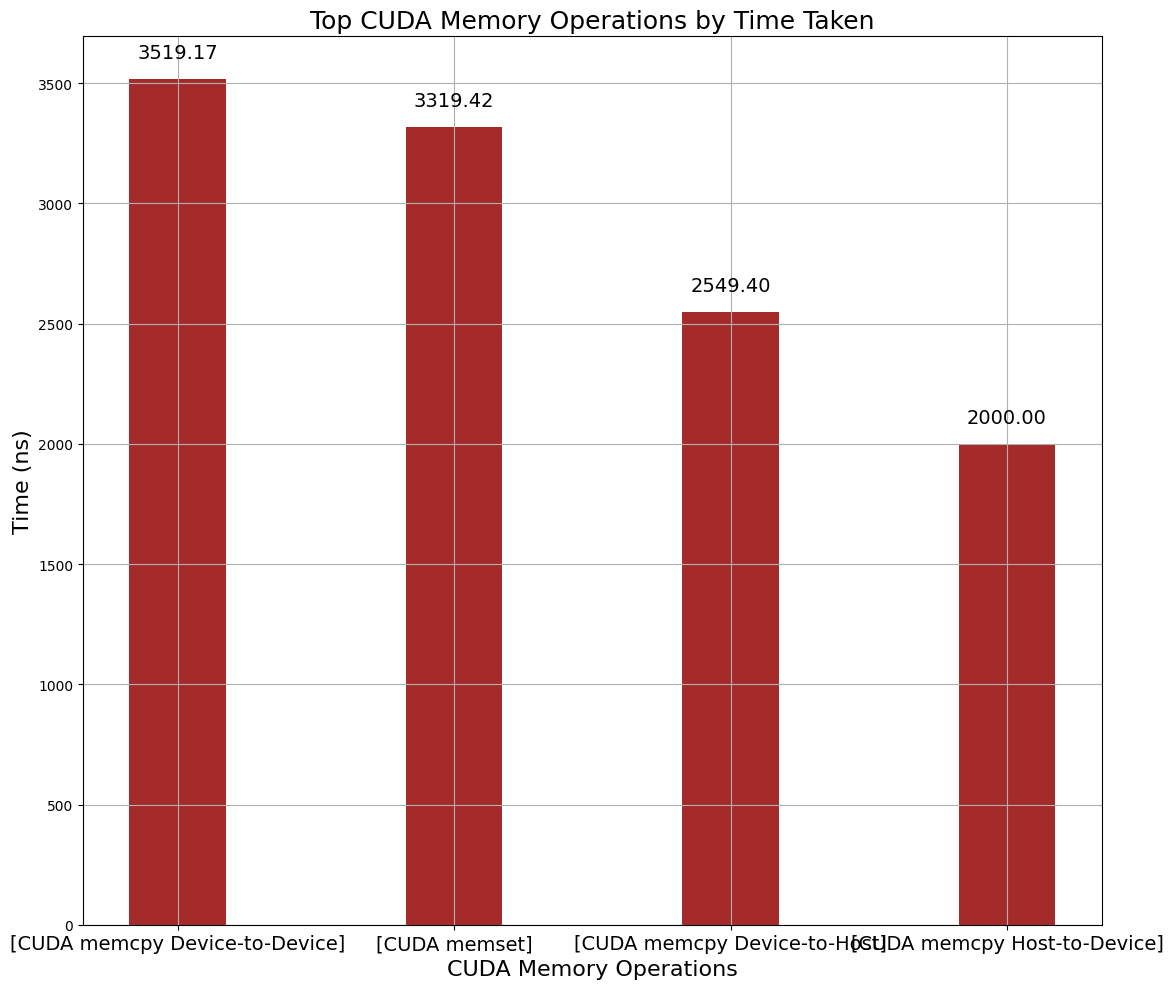

In [25]:
# Plot the top 5 CUDA Memory operations by time taken ('Avg (ns)')
plot_time(df = df_cuda_memtime_summary,
            title = "Top CUDA Memory Operations by Time Taken",
            limit = 5,
            time_col = 'Avg (ns)',
            name_col = 'Operation',
            label_col = 'Avg (ns)',
            x_label = "CUDA Memory Operations",
            y_label = "Time (ns)",
            legend_label = "Time (ns)",
            bar_color = 'brown',
            figsize = (12, 10),
            legends = False,
            bar_width = 0.15,
            xlabel_rotation = 0)

# CUDA Memsize Summary

In [26]:
cuda_memsize_summary_csv_path = BASE_PATH + "cuda_memsize_summary.csv"
df_cuda_memsize_summary = pd.read_csv(cuda_memsize_summary_csv_path)

In [27]:
df_cuda_memsize_summary

,Operation,Total (MB),Count,Avg (MB),Med (MB),Min (MB),Max (MB),StdDev (MB),Size_Percent
0,[CUDA memcpy Device-to-Device],44.672,4225,0.010573,0.008,0.0,0.128,0.016233,93.064728
1,[CUDA memcpy Device-to-Host],0.001,193,0.000005,0.000,0.0,0.001,0.000072,0.002083
2,[CUDA memcpy Host-to-Device],0.000,2,0.000000,0.000,0.0,0.000,0.000000,0.000000
3,[CUDA memset],3.328,384,0.008667,0.011,0.0,0.011,0.004033,6.933189


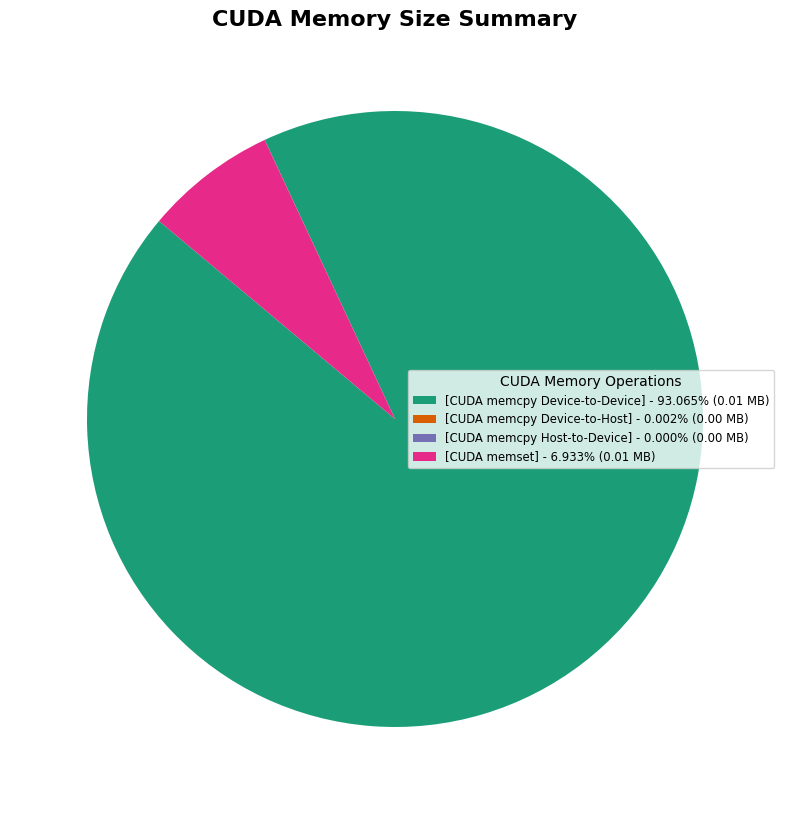

[]

In [28]:
other_items = plot_pie_chart(df = df_cuda_memsize_summary,
                # title = "CUDA Memory Size Summary Based on Percentage of Size consumed by each Memory Operation",
                title = "CUDA Memory Size Summary",
                threshold = 0.0000,
                percentage_col = 'Size_Percent',
                stat_col = 'Avg (MB)',
                stat_base = 'MB',
                legend_title = "CUDA Memory Operations",
                operation_col = "Operation",
                # Color with brown color palette other than tab20
                colors = sns.color_palette("Dark2", len(df_cuda_memsize_summary)),
                plt_title = "CUDA Memory Size Summary",
                figsize = (10, 10))                

other_items     

<Figure size 1000x600 with 0 Axes>

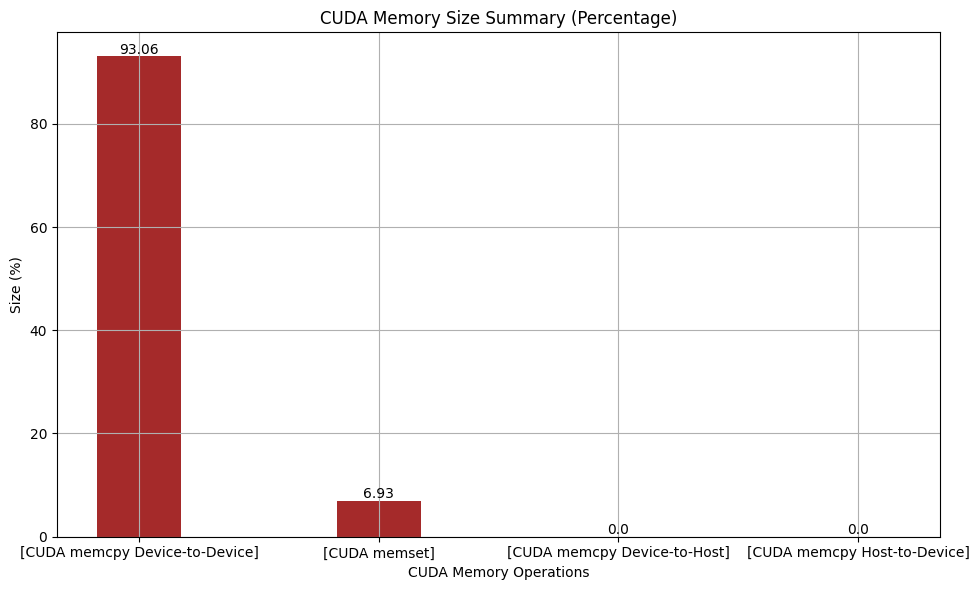

[]

In [29]:
other_items = plot_bar_chart(df = df_cuda_memsize_summary,
                title = "CUDA Memory Size Summary (Percentage)",
                threshold = 0.0000,
                percentage_col = 'Size_Percent',
                stat_col = 'Avg (MB)',
                stat_base = 'MB',
                operation_col = "Operation",
                x_label = "CUDA Memory Operations",
                y_label = "Size (%)",
                bar_label = "Size (%)",
                bar_color = 'brown',
                figsize = (10, 6),
                legends = False,
                bar_width = 0.35,
                xlabel_rotation = 0)

other_items

<Figure size 1200x1200 with 0 Axes>

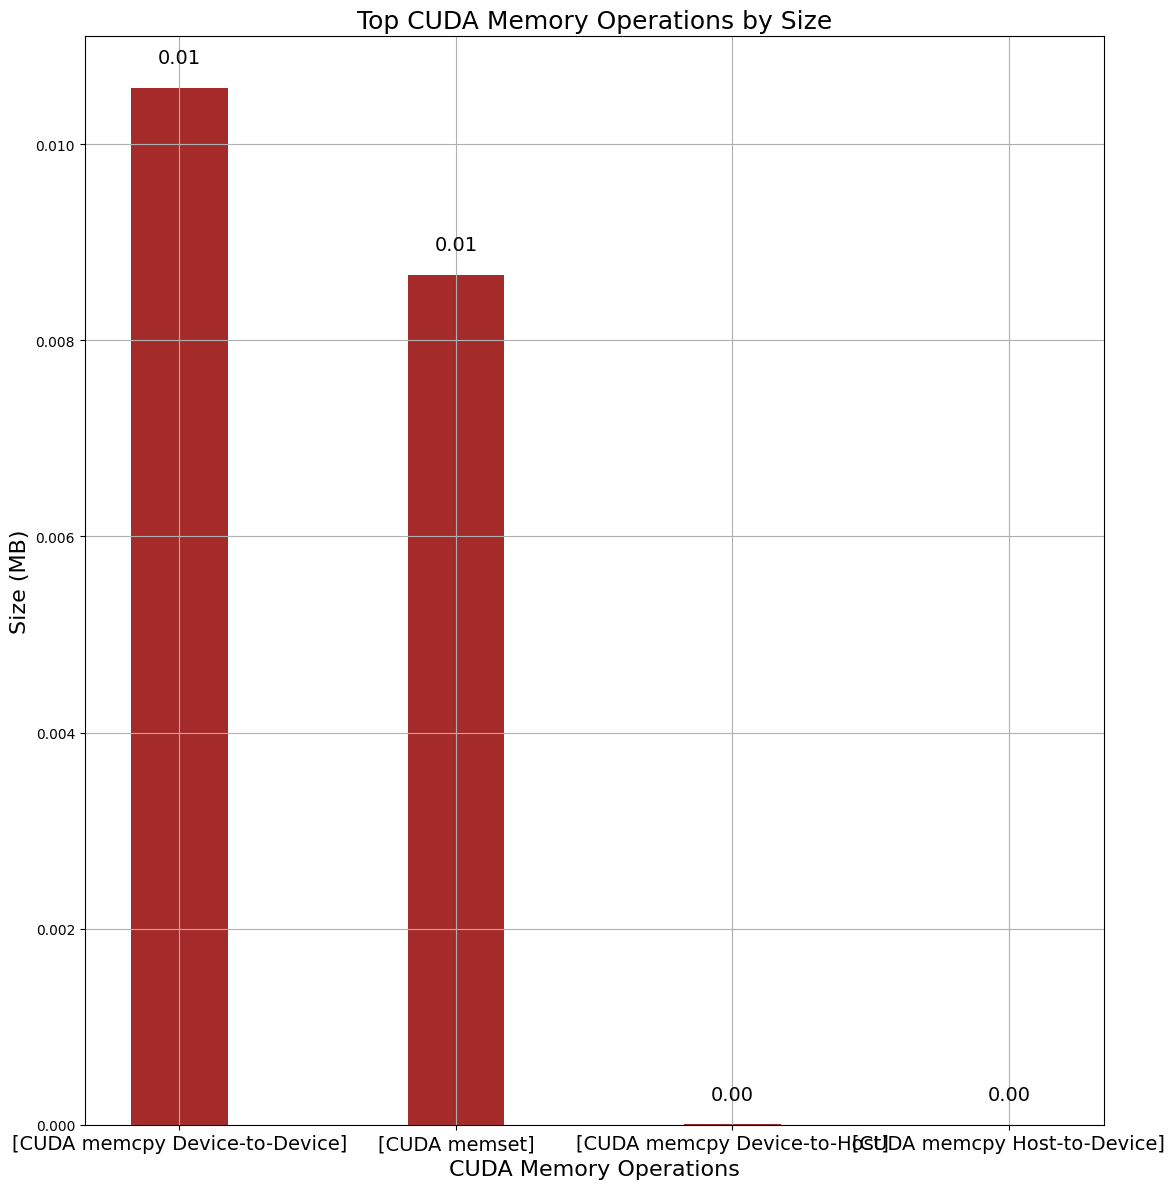

In [30]:
# Plot the top 10 CUDA Memory operations by size ('Size (bytes)')
plot_time(df = df_cuda_memsize_summary,
            title = "Top CUDA Memory Operations by Size",
            limit = 5,
            time_col = 'Avg (MB)',
            name_col = 'Operation',
            label_col = 'Avg (MB)',
            x_label = "CUDA Memory Operations",
            y_label = "Size (MB)",
            legend_label = "Size (MB)",
            bar_color = 'brown',
            figsize = (12, 12),
            legends = False,
            bar_width = 0.15,
            xlabel_rotation = 0)

# Kernel Summaries

In [31]:
# cuda_kernel_launch_and_exec_time_summary_short.csv
df_cuda_kernel_launch_and_exec_time_summary_short = pd.read_csv(BASE_PATH + "cuda_kernel_launch_and_exec_time_summary_short.csv")
df_cuda_kernel_launch_and_exec_time_summary_short

,PID,TID,DevId,Count,QCount,TAvg (ns),TMed (ns),TMin (ns),TMax (ns),TStdDev (ns),...,QMin (ns),QMax (ns),QStdDev (ns),KAvg (ns),KMed (ns),KMin (ns),KMax (ns),KStdDev (ns),API Function,Kernel Name
0,734,734,0,2,2,8.365530e+06,8365530.0,8365475,8365585,7.778175e+01,...,426.0,506.0,56.568542,5856.000000,5856.0,5856,5856,0.000000,cudaLaunchKernel,CatArrayBatchedCopy
1,734,734,0,128,128,4.880207e+06,22708.5,21729,310897009,3.870598e+07,...,784.0,2496.0,271.236524,6637.921875,6528.0,6272,15264,1098.890970,cudaLaunchKernel,indexSelectSmallIndex
2,734,734,0,2,2,1.592774e+06,1592774.0,1592729,1592819,6.363961e+01,...,1724.0,1844.0,84.852814,5824.000000,5824.0,5824,5824,0.000000,cudaLaunchKernel,triu_tril_kernel
3,734,734,0,126,126,2.279375e+05,227704.5,224289,236569,1.838309e+03,...,26.0,2391.0,415.420203,211808.079365,211968.0,209728,213249,793.537141,cudaLaunchKernel,ampere_fp16_s16816gemm_fp16_128x64_ldg8_f2f_stages_64x4_tn
4,734,734,0,130,130,9.495818e+04,92513.0,90489,233398,1.742427e+04,...,772.0,2429.0,229.823374,80639.307692,78145.0,76129,219265,17438.834122,cudaLaunchKernel,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x5_tn
5,734,734,0,8064,8064,9.069686e+04,90356.0,87582,380578,6.516663e+03,...,6.0,286053.0,4603.254861,76102.103175,76000.0,73120,83424,1036.731323,cudaLaunchKernel,ampere_fp16_s16816gemm_fp16_64x64_ldg8_f2f_stages_64x5_tn
6,734,734,0,128,128,7.286530e+04,15390.5,14457,3669167,4.548686e+05,...,369.0,2365.0,368.746615,4143.031250,4128.0,4096,4192,22.652436,cudaLaunchKernel,fill_reverse_indices_kernel
7,734,734,0,20480,20480,5.814587e+04,49249.0,47915,421390,1.833081e+04,...,14.0,370512.0,4708.262488,44054.134277,35040.0,34176,83776,18129.193032,cudaLaunchKernel,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x6_tn
8,734,734,0,128,128,5.130805e+04,50327.5,48552,100187,6.259185e+03,...,474.0,2689.0,349.289509,36807.078125,36832.0,35904,37696,413.678650,cudaLaunchKernel,cunn_SoftMaxForward
9,734,734,0,128,128,3.304867e+04,17666.5,16632,987410,1.207093e+05,...,227.0,2373.0,329.582394,5537.046875,5536.0,5503,5600,23.394211,cudaLaunchKernel,distribution_elementwise_grid_stride_kernel


In [33]:
# print top 10 df items after sorting by 'KAvg (ns)'
df_top_10_cuda_kernel_launch_and_exec_time_summary_short = df_cuda_kernel_launch_and_exec_time_summary_short.sort_values(by='KAvg (ns)', ascending=False).head(10)

# Print "Operation", "Count", "KAvg (ns)", "API Function" columns
df_top_10_cuda_kernel_launch_and_exec_time_summary_short = df_top_10_cuda_kernel_launch_and_exec_time_summary_short[["Kernel Name", "Count", "KAvg (ns)", "API Function"]]
df_top_10_cuda_kernel_launch_and_exec_time_summary_short.index = np.arange(1, len(df_top_10_cuda_kernel_launch_and_exec_time_summary_short) + 1)
df_top_10_cuda_kernel_launch_and_exec_time_summary_short

,Kernel Name,Count,KAvg (ns),API Function
1,ampere_fp16_s16816gemm_fp16_128x64_ldg8_f2f_stages_64x4_tn,126,211808.08,cudaLaunchKernel
2,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x5_tn,130,80639.31,cudaLaunchKernel
3,ampere_fp16_s16816gemm_fp16_64x64_ldg8_f2f_stages_64x5_tn,8064,76102.10,cudaLaunchKernel
4,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x6_tn,20480,44054.13,cudaLaunchKernel
5,cunn_SoftMaxForward,128,36807.08,cudaLaunchKernel
6,Kernel,1536,11310.33,cudaLaunchKernel
7,reduce_kernel,9214,9441.21,cudaLaunchKernel
8,kernel,7680,7203.21,cudaLaunchKernel
9,unrolled_elementwise_kernel,41600,7054.70,cudaLaunchKernel
10,indexSelectSmallIndex,128,6637.92,cudaLaunchKernel


In [34]:
# print top 10 df items after sorting by 'KAvg (ns)'
df_top_10_cuda_kernel_launch_and_exec_time_summary_short = df_cuda_kernel_launch_and_exec_time_summary_short.sort_values(by='KAvg (ns)', ascending=False).head(10)

# Print "Operation", "Count", "KAvg (ns)", "API Function" columns
df_top_10_cuda_kernel_launch_and_exec_time_summary_short = df_top_10_cuda_kernel_launch_and_exec_time_summary_short[["Kernel Name", "Count", "KAvg (ns)", "AAvg (ns)", "TAvg (ns)", "QAvg (ns)", "API Function"]]
df_top_10_cuda_kernel_launch_and_exec_time_summary_short.index = np.arange(1, len(df_top_10_cuda_kernel_launch_and_exec_time_summary_short) + 1)
# df_top_10_cuda_kernel_launch_and_exec_time_summary_short
# Print all values without e+ notation
pd.options.display.float_format = '{:.2f}'.format
df_top_10_cuda_kernel_launch_and_exec_time_summary_short

,Kernel Name,Count,KAvg (ns),AAvg (ns),TAvg (ns),QAvg (ns),API Function
1,ampere_fp16_s16816gemm_fp16_128x64_ldg8_f2f_stages_64x4_tn,126,211808.08,15028.34,227937.46,1233.79,cudaLaunchKernel
2,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x5_tn,130,80639.31,12453.05,94958.18,1927.19,cudaLaunchKernel
3,ampere_fp16_s16816gemm_fp16_64x64_ldg8_f2f_stages_64x5_tn,8064,76102.10,12809.12,90696.86,1927.45,cudaLaunchKernel
4,ampere_fp16_s16816gemm_fp16_64x64_sliced1x2_ldg8_f2f_stages_64x6_tn,20480,44054.13,12170.90,58145.87,2038.72,cudaLaunchKernel
5,cunn_SoftMaxForward,128,36807.08,12602.17,51308.05,1939.56,cudaLaunchKernel
6,Kernel,1536,11310.33,12075.38,25438.92,2189.80,cudaLaunchKernel
7,reduce_kernel,9214,9441.21,20583.85,31968.16,2073.79,cudaLaunchKernel
8,kernel,7680,7203.21,12754.40,21681.65,1855.75,cudaLaunchKernel
9,unrolled_elementwise_kernel,41600,7054.70,12244.38,20991.07,1825.96,cudaLaunchKernel
10,indexSelectSmallIndex,128,6637.92,4872356.47,4880206.84,1405.59,cudaLaunchKernel


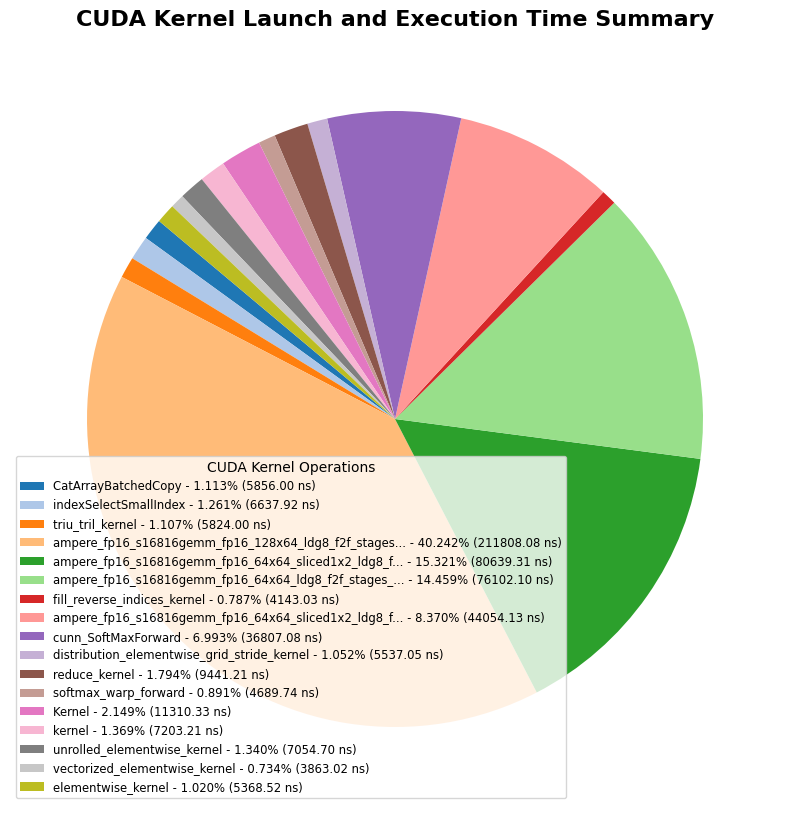

[]

In [100]:
# Plot the top 10 CUDA Kernel operations by time taken ('KAvg (ns)')
# Calculate the percentage of time taken by each operation
df_cuda_kernel_launch_and_exec_time_summary_short['Time (%)'] = (df_cuda_kernel_launch_and_exec_time_summary_short['KAvg (ns)'] / df_cuda_kernel_launch_and_exec_time_summary_short['KAvg (ns)'].sum()) * 100

plot_pie_chart(df = df_cuda_kernel_launch_and_exec_time_summary_short,
                title = "CUDA Kernel Launch and Execution Time Summary",
                threshold = 0.5,
                percentage_col = 'Time (%)',
                stat_col = 'KAvg (ns)',
                stat_base = 'ns',
                legend_title = "CUDA Kernel Operations",
                operation_col = "Kernel Name",
                colors = sns.color_palette("tab20", len(df_cuda_kernel_launch_and_exec_time_summary_short)),
                plt_title = "CUDA Kernel Launch and Execution Time Summary",
                figsize = (10, 10))

# NVTX GPU Proj Summary

In [101]:
nvtx_gpu_proj_summary_csv_path = BASE_PATH + "nvtx_gpu_proj_summary.csv"
df_nvtx_gpu_proj_summary = pd.read_csv(nvtx_gpu_proj_summary_csv_path)

In [102]:
df_nvtx_gpu_proj_summary

,Name,Style,Total_Proj_Time_ns,Total_Range_Time_ns,Range_Instances,Proj_Avg_ns,Proj_Med_ns,Proj_Min_ns,Proj_Max_ns,Proj_StdDev_ns,Total_GPU_Ops,Avg_GPU_Ops,Avg_Range_Lvl,Avg_Num_Child
0,0: TransformerBlock,PushPop,1890929084,1919259118,64,2.954577e+07,23772292.5,22963361,360374211,4.220020e+07,2626,41.03125,1417.0,6.0
1,10: TransformerBlock,PushPop,1518637851,1545919864,64,2.372872e+07,23594915.5,23073346,24897127,4.384218e+05,2626,41.03125,1417.0,6.0
2,11: TransformerBlock,PushPop,1521579865,1549786467,64,2.377469e+07,23756660.5,22959905,25417960,4.944287e+05,2626,41.03125,1417.0,6.0
3,12: TransformerBlock,PushPop,1519308728,1547110134,64,2.373920e+07,23633460.0,22965281,24780456,4.287689e+05,2626,41.03125,1417.0,6.0
4,13: TransformerBlock,PushPop,1517180526,1544170349,64,2.370595e+07,23573684.0,22796417,24785542,4.517632e+05,2626,41.03125,1417.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175042,"{'traceMarker': ['/home/llama/example_text_completion.py:74', '/root/miniconda3/envs/llama-profi...",PushPop,249442,26817231,64,3.897531e+03,3920.0,3776,4128,8.450340e+01,64,1.00000,1416.0,1.0
175043,"{'traceMarker': ['/home/llama/example_text_completion.py:74', '/root/miniconda3/envs/llama-profi...",PushPop,234079,12571056,64,3.657484e+03,3648.0,3615,4064,7.405961e+01,64,1.00000,1416.0,1.0
175044,"{'traceMarker': ['/home/llama/example_text_completion.py:74', '/root/miniconda3/envs/llama-profi...",PushPop,223393,10004770,64,3.490516e+03,3488.5,3296,3617,9.666289e+01,64,1.00000,1416.0,1.0
175045,"{'traceMarker': ['/home/llama/example_text_completion.py:74', '/root/miniconda3/envs/llama-profi...",PushPop,244033,11277646,64,3.813016e+03,3840.0,3616,4000,7.437987e+01,64,1.00000,1416.0,1.0


In [103]:
# Variables for customization
# Remove all rows where "Avg_GPU_Ops" is NaN or 0
df_nvtx_gpu_proj_summary = df_nvtx_gpu_proj_summary.dropna(subset=['Avg_GPU_Ops'])
df_nvtx_gpu_proj_summary = df_nvtx_gpu_proj_summary[df_nvtx_gpu_proj_summary['Avg_GPU_Ops'] != 0]

# Remove all "Name" that include "/home" or "traceMarker" and recalculate the time percentage
# Use regex to filter out the rows
df_nvtx_gpu_proj_summary = df_nvtx_gpu_proj_summary[~df_nvtx_gpu_proj_summary['Name'].str.contains('(/home|traceMarker)')]

/var/folders/sg/b1qbnvkj7fjbgjw1kzc9drzw0000gn/T/ipykernel_38876/2275252559.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_nvtx_gpu_proj_summary = df_nvtx_gpu_proj_summary[~df_nvtx_gpu_proj_summary['Name'].str.contains('(/home|traceMarker)')]


In [104]:
# Plot top n average GPU operations
df_gpu_proj_topn = df_nvtx_gpu_proj_summary.sort_values(by='Avg_GPU_Ops', ascending=False).head(100)

# Print the Name, Avg_GPU_Ops, and Time (%) columns
df_sample = df_gpu_proj_topn[['Name', 'Avg_GPU_Ops']]

# Print top 20 rows
df_sample[20:50]

,Name,Avg_GPU_Ops
15,23: TransformerBlock,41.03125
2,11: TransformerBlock,41.03125
3,12: TransformerBlock,41.03125
5,14: TransformerBlock,41.03125
6,15: TransformerBlock,41.03125
7,16: TransformerBlock,41.03125
4,13: TransformerBlock,41.03125
9,18: TransformerBlock,41.03125
10,19: TransformerBlock,41.03125
11,1: TransformerBlock,41.03125


In [105]:
# Top 10 GPU operations by time taken "Proj_Avg_ns"
df_gpu_proj_topn = df_nvtx_gpu_proj_summary.sort_values(by='Proj_Avg_ns', ascending=False).head(10)

df_gpu_proj_topn

,Name,Style,Total_Proj_Time_ns,Total_Range_Time_ns,Range_Instances,Proj_Avg_ns,Proj_Med_ns,Proj_Min_ns,Proj_Max_ns,Proj_StdDev_ns,Total_GPU_Ops,Avg_GPU_Ops,Avg_Range_Lvl,Avg_Num_Child
32,Transformer,PushPop,50332623927,50726710437,64,7.864472e+08,776705784.5,756234881,1189367355,5.253455e+07,84802,1325.03125,1416.0,36.046875
0,0: TransformerBlock,PushPop,1890929084,1919259118,64,2.954577e+07,23772292.5,22963361,360374211,4.220020e+07,2626,41.03125,1417.0,6.000000
130410,"aten::multinomial, op_id = 7315",PushPop,26376140,36072280,1,2.637614e+07,26376140.0,26376140,26376140,0.000000e+00,14,14.00000,1418.0,13.000000
30,8: TransformerBlock,PushPop,1556723976,1584640405,64,2.432381e+07,23739812.5,22969410,61791248,4.775385e+06,2626,41.03125,1417.0,6.000000
24,31: TransformerBlock,PushPop,1528410583,1555819011,64,2.388142e+07,23667076.5,22985442,33068383,1.236113e+06,2626,41.03125,1417.0,6.000000
7,16: TransformerBlock,PushPop,1526844558,1554427474,64,2.385695e+07,23744708.5,23111425,26990189,6.016541e+05,2626,41.03125,1417.0,6.000000
18,26: TransformerBlock,PushPop,1525682253,1553432661,64,2.383879e+07,23750356.5,22844641,28029360,7.495654e+05,2626,41.03125,1417.0,6.000000
9,18: TransformerBlock,PushPop,1524321506,1551784974,64,2.381752e+07,23812708.0,22937921,26055115,5.233608e+05,2626,41.03125,1417.0,6.000000
16,24: TransformerBlock,PushPop,1523645448,1551438796,64,2.380696e+07,23818900.0,22779616,28528945,7.275842e+05,2626,41.03125,1417.0,6.000000
27,5: TransformerBlock,PushPop,1522141564,1549815090,64,2.378346e+07,23705396.0,22885761,26887660,5.514709e+05,2626,41.03125,1417.0,6.000000


In [106]:
# csv_path = "/Users/shamweelmohammed/Desktop/Masters/Research/trace/apr19/nvtx_pushpop_trace.csv"
nvtx_gpu_proj_trace_csv_path = REPORTS_PATH + "nvtx_gpu_proj_trace.csv"

# Load the CSV data into a DataFrame
df_nvtx_gpu_proj_trace = pd.read_csv(nvtx_gpu_proj_trace_csv_path)

In [41]:
df_nvtx_gpu_proj_trace

,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,NumChild,RangeId,ParentId,RangeStack
0,"{'traceMarker': ['/home/llama/example_text_completion.py:6', '<frozen importlib._bootstrap>:1027...",9255113734,58108556024,2804473360,69103057055,PushPop,734,734,88119,0,1,3877,NaN,:3877
1,"{'mod': 'torch', 'op': '__getattr__', 'args': []}",9255113734,58108556024,2804485120,69103045295,PushPop,734,734,88119,1,1,3878,3877.0,:3877:3878
2,"{'traceMarker': ['/home/llama/example_text_completion.py:6', '<frozen importlib._bootstrap>:1027...",9255113734,58108556024,2804678389,69102852026,PushPop,734,734,88119,2,1,3879,3878.0,:3877:3878:3879
3,"{'mod': 'torch', 'op': '__getattr__', 'args': []}",9255113734,58108556024,2804686929,69102843486,PushPop,734,734,88119,3,1,3880,3879.0,:3877:3878:3879:3880
4,"{'traceMarker': ['/home/llama/example_text_completion.py:6', '<frozen importlib._bootstrap>:1027...",9255113734,58108556024,2804866478,69102663937,PushPop,734,734,88119,4,1,3881,3880.0,:3877:3878:3879:3880:3881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368899,"aten::item, op_id = 458083",67363390493,2496,67363371758,241859,PushPop,734,734,1,1417,1,981615,981614.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
368900,"aten::_local_scalar_dense, op_id = 458084",67363390493,2496,67363372998,240149,PushPop,734,734,1,1418,0,981616,981615.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
368901,"aten::to, op_id = 458087",67363666974,2784,67363632037,213899,PushPop,734,734,1,1416,1,981622,6462.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
368902,"aten::_to_copy, op_id = 458088",67363666974,2784,67363633597,211919,PushPop,734,734,1,1417,1,981623,981622.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...


In [107]:
def filter_and_plot_gpu_operations(df, name_start, name_end, lvl, level_name='Lvl'):
    # Finding the first occurrence indices
    # start_index = df[df['Name'] == name_start].index[0]
    # end_index = df[df['Name'] == name_end].index[0]
    if name_start == name_end:
        # Find the first and second occurrences of the same name
        indices = df[df['Name'] == name_start].index
        start_index = indices[0]
        end_index = indices[1]
    else:
        # Finding the first occurrence indices
        start_index = df[df['Name'] == name_start].index[0]
        end_index = df[df['Name'] == name_end].index[0]

    print(f"Start Index: {start_index}")
    print(f"End Index: {end_index}")

    # Selecting the rows between the indices with the specified level
    # df_selected = df_nvtx_gpu_proj_trace[(df_nvtx_gpu_proj_trace.index > start_index) & (df_nvtx_gpu_proj_trace.index < end_index)]
    # df_selected = df[(df.index > start_index) & 
    #                  (df.index < end_index) &
    #                  (df[level_name] == lvl)]
    df_selected = df[(df.index > start_index) & 
                     (df.index < end_index)]
    
    if lvl is not None:
        df_selected = df_selected[df_selected[level_name] == lvl]

    # Remove rows with "Name" containing "/home" or "traceMarker"
    df_selected = df_selected[~df_selected['Name'].str.contains('(/home|traceMarker)')]
    
    print("Selected Rows after filtering:")
    display(df_selected)

    # Print all unique values in the "Name" column
    print("Unique Names:", df_selected['Name'].unique())

    # Add a new column "Time (%)" to show the percentage of time taken by each operation
    df_selected["Time (%)"] = (df_selected["Projected Duration (ns)"] / df_selected["Projected Duration (ns)"].sum()) * 100
    
    print("Selected Rows after adding Time (%):")
    # Displaying the selected rows using display() function
    display(df_selected)
    
    # Plot Pie Chart for the top 10 GPU operations by time taken "Proj_Avg_ns"
    other_items = plot_pie_chart(df = df_selected,
                    title = f"Top GPU Operations by Time Taken inside {name_start}",
                    threshold = 0.5,
                    percentage_col = 'Time (%)',
                    stat_col = 'Projected Duration (ns)',
                    stat_base = 'ns',
                    legend_title = "Operations",
                    operation_col = "Name",
                    colors = sns.color_palette("tab20", len(df_selected)),
                    plt_title = f"Top GPU Operations by Time Taken inside a {name_start}",
                    figsize = (10, 10))

### Complete Analysis

Start Index: 2298
End Index: 8226
Selected Rows after filtering:


/var/folders/sg/b1qbnvkj7fjbgjw1kzc9drzw0000gn/T/ipykernel_38876/3324450821.py:30: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_selected = df_selected[~df_selected['Name'].str.contains('(/home|traceMarker)')]


,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,NumChild,RangeId,ParentId,RangeStack
2299,tok_embeddings: ParallelEmbedding,16367389182,15264,16054716267,313858936,PushPop,734,734,1,1417,1,34938,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2317,0: TransformerBlock,16380786212,360374211,16380438077,360867255,PushPop,734,734,43,1417,6,35610,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2498,1: TransformerBlock,16741606984,24707302,16741314802,25139790,PushPop,734,734,43,1417,6,36712,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2679,2: TransformerBlock,16766737776,24511429,16766461902,24926092,PushPop,734,734,43,1417,6,37176,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2860,3: TransformerBlock,16791671030,24017541,16791394804,24429294,PushPop,734,734,43,1417,6,37639,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
3041,4: TransformerBlock,16816234045,24207812,16815832078,24741332,PushPop,734,734,43,1417,6,38101,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
3222,5: TransformerBlock,16840851907,24198788,16840581160,24603464,PushPop,734,734,43,1417,6,38563,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
3403,6: TransformerBlock,16865476937,24915751,16865192274,25340569,PushPop,734,734,43,1417,6,39025,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
3584,7: TransformerBlock,16890815153,24614726,16890540353,25032161,PushPop,734,734,43,1417,6,39489,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
3765,8: TransformerBlock,16915859768,61791248,16915581434,62202194,PushPop,734,734,43,1417,6,39952,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...


Unique Names: ['tok_embeddings: ParallelEmbedding' '0: TransformerBlock'
 '1: TransformerBlock' '2: TransformerBlock' '3: TransformerBlock'
 '4: TransformerBlock' '5: TransformerBlock' '6: TransformerBlock'
 '7: TransformerBlock' '8: TransformerBlock' '9: TransformerBlock'
 '10: TransformerBlock' '11: TransformerBlock' '12: TransformerBlock'
 '13: TransformerBlock' '14: TransformerBlock' '15: TransformerBlock'
 '16: TransformerBlock' '17: TransformerBlock' '18: TransformerBlock'
 '19: TransformerBlock' '20: TransformerBlock' '21: TransformerBlock'
 '22: TransformerBlock' '23: TransformerBlock' '24: TransformerBlock'
 '25: TransformerBlock' '26: TransformerBlock' '27: TransformerBlock'
 '28: TransformerBlock' '29: TransformerBlock' '30: TransformerBlock'
 '31: TransformerBlock' 'norm: RMSNorm' 'output: ColumnParallelLinear'
 "{'mod': 'Tensor', 'op': '__truediv__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 32000), 'dtype': 'float32'}]}"
 "{'mod': 'torch', 'op': 'softmax', 'arg

,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,NumChild,RangeId,ParentId,RangeStack,Time (%)
2299,tok_embeddings: ParallelEmbedding,16367389182,15264,16054716267,313858936,PushPop,734,734,1,1417,1,34938,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,0.001263
2317,0: TransformerBlock,16380786212,360374211,16380438077,360867255,PushPop,734,734,43,1417,6,35610,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,29.826840
2498,1: TransformerBlock,16741606984,24707302,16741314802,25139790,PushPop,734,734,43,1417,6,36712,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,2.044932
2679,2: TransformerBlock,16766737776,24511429,16766461902,24926092,PushPop,734,734,43,1417,6,37176,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,2.028720
2860,3: TransformerBlock,16791671030,24017541,16791394804,24429294,PushPop,734,734,43,1417,6,37639,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,1.987843
3041,4: TransformerBlock,16816234045,24207812,16815832078,24741332,PushPop,734,734,43,1417,6,38101,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,2.003591
3222,5: TransformerBlock,16840851907,24198788,16840581160,24603464,PushPop,734,734,43,1417,6,38563,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,2.002844
3403,6: TransformerBlock,16865476937,24915751,16865192274,25340569,PushPop,734,734,43,1417,6,39025,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,2.062185
3584,7: TransformerBlock,16890815153,24614726,16890540353,25032161,PushPop,734,734,43,1417,6,39489,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,2.037270
3765,8: TransformerBlock,16915859768,61791248,16915581434,62202194,PushPop,734,734,43,1417,6,39952,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,5.114233


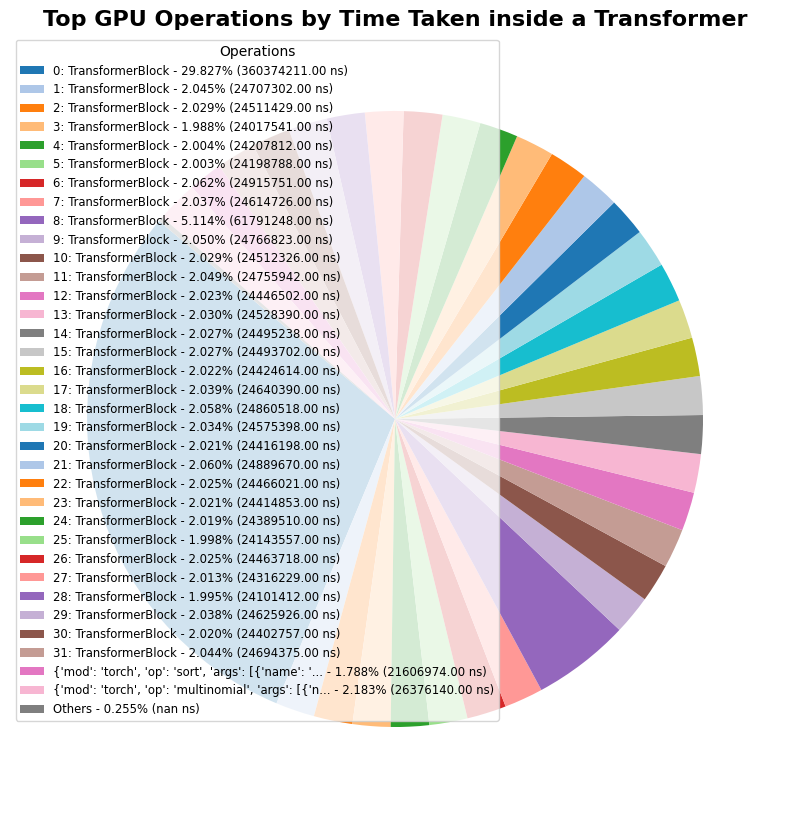

In [108]:
filter_and_plot_gpu_operations(df_nvtx_gpu_proj_trace, "Transformer", "Transformer", 1417)

### Transformer Analysis

Start Index: 2298
End Index: 8226
Selected Rows after filtering:


/var/folders/sg/b1qbnvkj7fjbgjw1kzc9drzw0000gn/T/ipykernel_38876/3324450821.py:30: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_selected = df_selected[~df_selected['Name'].str.contains('(/home|traceMarker)')]


,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,NumChild,RangeId,ParentId,RangeStack
2299,tok_embeddings: ParallelEmbedding,16367389182,15264,16054716267,313858936,PushPop,734,734,1,1417,1,34938,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2317,0: TransformerBlock,16380786212,360374211,16380438077,360867255,PushPop,734,734,43,1417,6,35610,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2498,1: TransformerBlock,16741606984,24707302,16741314802,25139790,PushPop,734,734,43,1417,6,36712,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2679,2: TransformerBlock,16766737776,24511429,16766461902,24926092,PushPop,734,734,43,1417,6,37176,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2860,3: TransformerBlock,16791671030,24017541,16791394804,24429294,PushPop,734,734,43,1417,6,37639,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
3041,4: TransformerBlock,16816234045,24207812,16815832078,24741332,PushPop,734,734,43,1417,6,38101,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
3222,5: TransformerBlock,16840851907,24198788,16840581160,24603464,PushPop,734,734,43,1417,6,38563,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
3403,6: TransformerBlock,16865476937,24915751,16865192274,25340569,PushPop,734,734,43,1417,6,39025,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
3584,7: TransformerBlock,16890815153,24614726,16890540353,25032161,PushPop,734,734,43,1417,6,39489,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
3765,8: TransformerBlock,16915859768,61791248,16915581434,62202194,PushPop,734,734,43,1417,6,39952,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...


Unique Names: ['tok_embeddings: ParallelEmbedding' '0: TransformerBlock'
 '1: TransformerBlock' '2: TransformerBlock' '3: TransformerBlock'
 '4: TransformerBlock' '5: TransformerBlock' '6: TransformerBlock'
 '7: TransformerBlock' '8: TransformerBlock' '9: TransformerBlock'
 '10: TransformerBlock' '11: TransformerBlock' '12: TransformerBlock'
 '13: TransformerBlock' '14: TransformerBlock' '15: TransformerBlock'
 '16: TransformerBlock' '17: TransformerBlock' '18: TransformerBlock'
 '19: TransformerBlock' '20: TransformerBlock' '21: TransformerBlock'
 '22: TransformerBlock' '23: TransformerBlock' '24: TransformerBlock'
 '25: TransformerBlock' '26: TransformerBlock' '27: TransformerBlock'
 '28: TransformerBlock' '29: TransformerBlock' '30: TransformerBlock'
 '31: TransformerBlock' 'norm: RMSNorm' 'output: ColumnParallelLinear'
 "{'mod': 'Tensor', 'op': '__truediv__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 32000), 'dtype': 'float32'}]}"
 "{'mod': 'torch', 'op': 'softmax', 'arg

,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,NumChild,RangeId,ParentId,RangeStack,Time (%)
2299,tok_embeddings: ParallelEmbedding,16367389182,15264,16054716267,313858936,PushPop,734,734,1,1417,1,34938,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,0.001263
2317,0: TransformerBlock,16380786212,360374211,16380438077,360867255,PushPop,734,734,43,1417,6,35610,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,29.826840
2498,1: TransformerBlock,16741606984,24707302,16741314802,25139790,PushPop,734,734,43,1417,6,36712,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,2.044932
2679,2: TransformerBlock,16766737776,24511429,16766461902,24926092,PushPop,734,734,43,1417,6,37176,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,2.028720
2860,3: TransformerBlock,16791671030,24017541,16791394804,24429294,PushPop,734,734,43,1417,6,37639,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,1.987843
3041,4: TransformerBlock,16816234045,24207812,16815832078,24741332,PushPop,734,734,43,1417,6,38101,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,2.003591
3222,5: TransformerBlock,16840851907,24198788,16840581160,24603464,PushPop,734,734,43,1417,6,38563,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,2.002844
3403,6: TransformerBlock,16865476937,24915751,16865192274,25340569,PushPop,734,734,43,1417,6,39025,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,2.062185
3584,7: TransformerBlock,16890815153,24614726,16890540353,25032161,PushPop,734,734,43,1417,6,39489,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,2.037270
3765,8: TransformerBlock,16915859768,61791248,16915581434,62202194,PushPop,734,734,43,1417,6,39952,34937.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,5.114233


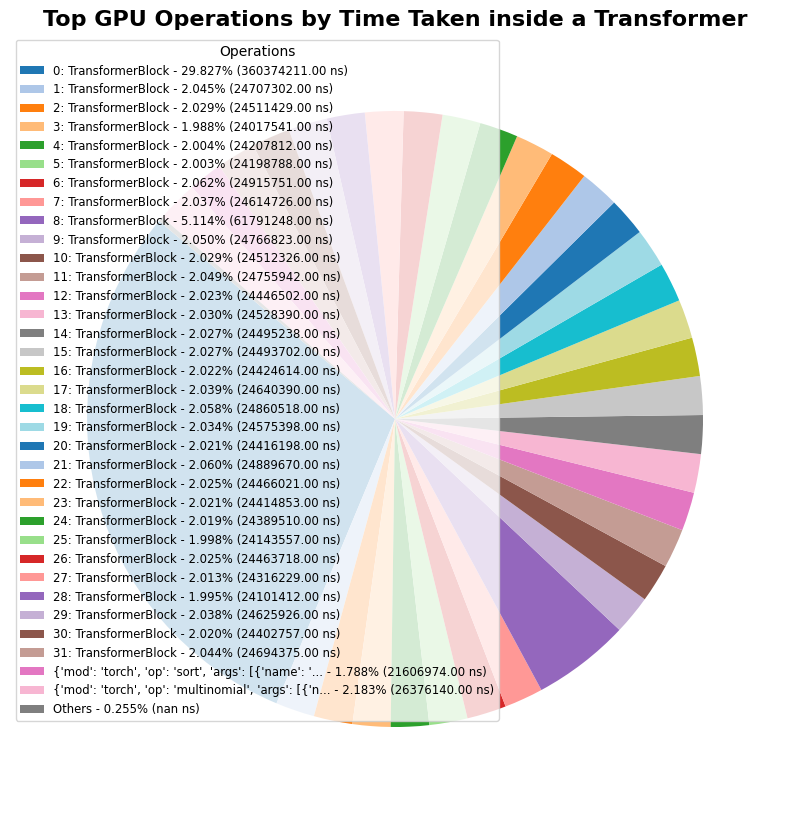

In [109]:
filter_and_plot_gpu_operations(df_nvtx_gpu_proj_trace, "Transformer", "Transformer", 1417)

### tok_embeddings: ParallelEmbedding Analysis

Start Index: 2299
End Index: 2306
Selected Rows after filtering:


/var/folders/sg/b1qbnvkj7fjbgjw1kzc9drzw0000gn/T/ipykernel_38876/3324450821.py:30: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_selected = df_selected[~df_selected['Name'].str.contains('(/home|traceMarker)')]


,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,NumChild,RangeId,ParentId,RangeStack
2301,"{'mod': 'torch.nn.functional', 'op': 'embedding', 'args': [{'name': '', 'type': 'tensor', 'shape...",16367389182,15264,16055854521,311887767,PushPop,734,734,1,1419,1,34948,34946.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2303,"{'mod': 'torch', 'op': 'embedding', 'args': [{'name': '', 'type': 'tensor', 'shape': (32000, 409...",16367389182,15264,16056377608,311359150,PushPop,734,734,1,1421,1,34953,34952.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2304,"aten::embedding, op_id = 31",16367389182,15264,16056396178,311321670,PushPop,734,734,1,1422,1,34954,34953.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2305,"aten::index_select, op_id = 34",16367389182,15264,16056421147,311261141,PushPop,734,734,1,1423,0,34957,34954.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...


Unique Names: ["{'mod': 'torch.nn.functional', 'op': 'embedding', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8), 'dtype': 'int64'}, {'name': '', 'type': 'tensor', 'shape': (32000, 4096), 'dtype': 'float16'}]}"
 "{'mod': 'torch', 'op': 'embedding', 'args': [{'name': '', 'type': 'tensor', 'shape': (32000, 4096), 'dtype': 'float16'}, {'name': '', 'type': 'tensor', 'shape': (1, 8), 'dtype': 'int64'}]}"
 'aten::embedding, op_id = 31' 'aten::index_select, op_id = 34']
Selected Rows after adding Time (%):


,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,NumChild,RangeId,ParentId,RangeStack,Time (%)
2301,"{'mod': 'torch.nn.functional', 'op': 'embedding', 'args': [{'name': '', 'type': 'tensor', 'shape...",16367389182,15264,16055854521,311887767,PushPop,734,734,1,1419,1,34948,34946.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,25.0
2303,"{'mod': 'torch', 'op': 'embedding', 'args': [{'name': '', 'type': 'tensor', 'shape': (32000, 409...",16367389182,15264,16056377608,311359150,PushPop,734,734,1,1421,1,34953,34952.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,25.0
2304,"aten::embedding, op_id = 31",16367389182,15264,16056396178,311321670,PushPop,734,734,1,1422,1,34954,34953.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,25.0
2305,"aten::index_select, op_id = 34",16367389182,15264,16056421147,311261141,PushPop,734,734,1,1423,0,34957,34954.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,25.0


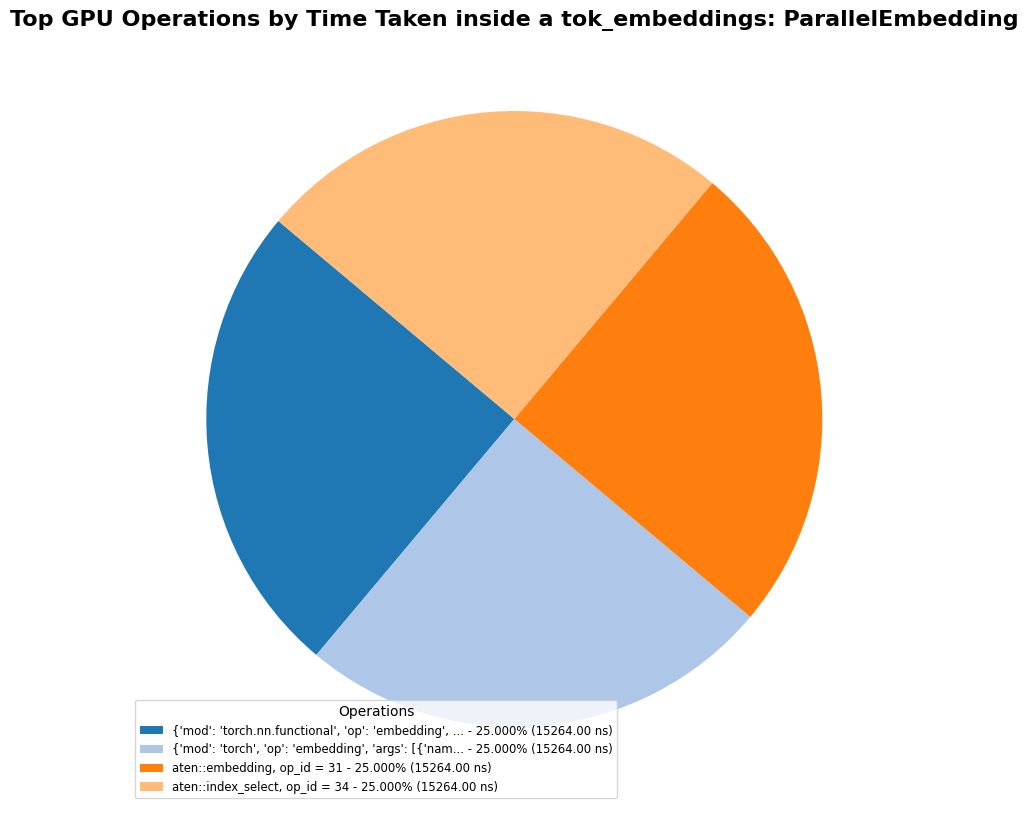

In [113]:
filter_and_plot_gpu_operations(df_nvtx_gpu_proj_trace, "tok_embeddings: ParallelEmbedding",
                               "{'traceMarker': ['/home/llama/example_text_completion.py:74', '/root/miniconda3/envs/llama-profiling/lib/python3.10/site-packages/fire/core.py:143', '/root/miniconda3/envs/llama-profiling/lib/python3.10/site-packages/fire/core.py:477', '/root/miniconda3/envs/llama-profiling/lib/python3.10/site-packages/fire/core.py:693', '/home/llama/example_text_completion.py:60', '/home/llama/llama/generation.py:274', '/root/miniconda3/envs/llama-profiling/lib/python3.10/site-packages/torch/utils/_contextlib.py:115', '/home/llama/llama/generation.py:193', '/root/miniconda3/envs/llama-profiling/lib/python3.10/site-packages/autonvtx/__init__.py:18', '/root/miniconda3/envs/llama-profiling/lib/python3.10/site-packages/torch/utils/_contextlib.py:115', '/home/llama/llama/model.py:476'], 'funcStack': '/<module>/Fire/_Fire/_CallAndUpdateTrace/main/Llama::text_completion/decorate_context/Llama::generate/wrapped_forward/decorate_context/Transformer::forward/full'}",
                               lvl=None)

### Transformer Block Analysis

Start Index: 2317
End Index: 2498
Selected Rows after filtering:


/var/folders/sg/b1qbnvkj7fjbgjw1kzc9drzw0000gn/T/ipykernel_38876/4093825718.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_selected = df_selected[~df_selected['Name'].str.contains('(/home|traceMarker)')]


,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,NumChild,RangeId,ParentId,RangeStack
2318,attention_norm: RMSNorm,16380786212,49154220,16380450257,49631094,PushPop,734,734,8,1418,8,35611,35610.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2348,attention: Attention,16684915911,43585148,16430096151,299021729,PushPop,734,734,20,1418,20,35747,35610.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2440,ffn_norm: RMSNorm,16729799334,3072809,16729518457,3423621,PushPop,734,734,8,1418,8,36581,35610.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2470,feed_forward: FeedForward,16733731698,6755923,16732950508,7928446,PushPop,734,734,5,1418,5,36630,35610.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...


Unique Names: ['attention_norm: RMSNorm' 'attention: Attention' 'ffn_norm: RMSNorm'
 'feed_forward: FeedForward']
Selected Rows after adding Time (%):


,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,NumChild,RangeId,ParentId,RangeStack,Time (%)
2318,attention_norm: RMSNorm,16380786212,49154220,16380450257,49631094,PushPop,734,734,8,1418,8,35611,35610.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,47.923497
2348,attention: Attention,16684915911,43585148,16430096151,299021729,PushPop,734,734,20,1418,20,35747,35610.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,42.493863
2440,ffn_norm: RMSNorm,16729799334,3072809,16729518457,3423621,PushPop,734,734,8,1418,8,36581,35610.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,2.995872
2470,feed_forward: FeedForward,16733731698,6755923,16732950508,7928446,PushPop,734,734,5,1418,5,36630,35610.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,6.586768


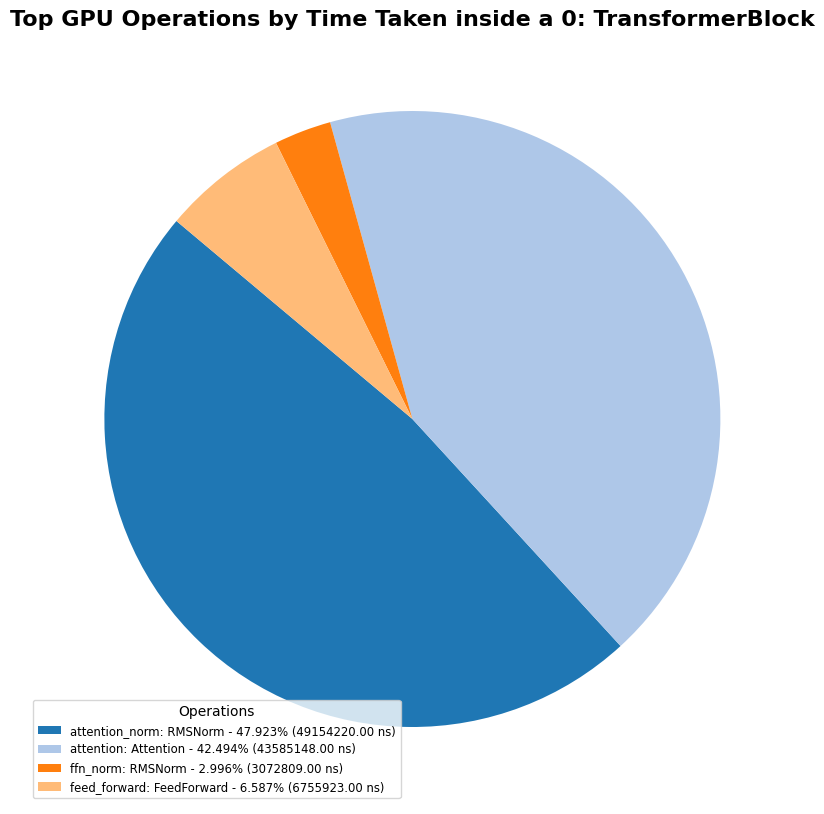

In [46]:
filter_and_plot_gpu_operations(df_nvtx_gpu_proj_trace, '0: TransformerBlock', '1: TransformerBlock', 1418)

### attention_norm: RMSNorm Analysis

Start Index: 2318
End Index: 2348
Selected Rows after filtering:


/var/folders/sg/b1qbnvkj7fjbgjw1kzc9drzw0000gn/T/ipykernel_38876/3324450821.py:30: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_selected = df_selected[~df_selected['Name'].str.contains('(/home|traceMarker)')]


,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,NumChild,RangeId,ParentId,RangeStack
2320,"{'mod': 'Tensor', 'op': 'float', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), ...",16380786212,7232,16380700676,245278,PushPop,734,734,1,1420,1,35614,35612.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2325,"{'mod': 'Tensor', 'op': 'pow', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), 'd...",16381356806,3616,16381191963,292118,PushPop,734,734,1,1420,1,35622,35621.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2328,"{'mod': 'Tensor', 'op': 'mean', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), '...",16389127132,14496,16381740850,7620208,PushPop,734,734,1,1420,1,35628,35627.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2331,"{'mod': 'Tensor', 'op': '__add__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 1), '...",16401529152,3232,16389788375,12040783,PushPop,734,734,1,1420,1,35648,35647.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2334,"{'mod': 'torch', 'op': 'rsqrt', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 1), 'dty...",16427906411,3360,16402354765,25848297,PushPop,734,734,1,1420,1,35676,35675.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2337,"{'mod': 'Tensor', 'op': '__mul__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096)...",16428832589,6176,16428700809,261948,PushPop,734,734,1,1420,1,35730,35729.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2340,"{'mod': 'Tensor', 'op': 'type_as', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096)...",16429379055,7456,16429208446,391208,PushPop,734,734,1,1420,1,35734,35733.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2346,"{'mod': 'Tensor', 'op': '__mul__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096)...",16429933136,7296,16429857792,219429,PushPop,734,734,1,1420,1,35744,35743.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...


Unique Names: ["{'mod': 'Tensor', 'op': 'float', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), 'dtype': 'float16'}]}"
 "{'mod': 'Tensor', 'op': 'pow', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), 'dtype': 'float32'}]}"
 "{'mod': 'Tensor', 'op': 'mean', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), 'dtype': 'float32'}]}"
 "{'mod': 'Tensor', 'op': '__add__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 1), 'dtype': 'float32'}]}"
 "{'mod': 'torch', 'op': 'rsqrt', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 1), 'dtype': 'float32'}]}"
 "{'mod': 'Tensor', 'op': '__mul__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), 'dtype': 'float32'}, {'name': '', 'type': 'tensor', 'shape': (1, 8, 1), 'dtype': 'float32'}]}"
 "{'mod': 'Tensor', 'op': 'type_as', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), 'dtype': 'float32'}, {'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), 'dtype': 'float16'}

,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,NumChild,RangeId,ParentId,RangeStack,Time (%)
2320,"{'mod': 'Tensor', 'op': 'float', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), ...",16380786212,7232,16380700676,245278,PushPop,734,734,1,1420,1,35614,35612.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,13.680387
2325,"{'mod': 'Tensor', 'op': 'pow', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), 'd...",16381356806,3616,16381191963,292118,PushPop,734,734,1,1420,1,35622,35621.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,6.840194
2328,"{'mod': 'Tensor', 'op': 'mean', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), '...",16389127132,14496,16381740850,7620208,PushPop,734,734,1,1420,1,35628,35627.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,27.421308
2331,"{'mod': 'Tensor', 'op': '__add__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 1), '...",16401529152,3232,16389788375,12040783,PushPop,734,734,1,1420,1,35648,35647.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,6.113801
2334,"{'mod': 'torch', 'op': 'rsqrt', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 1), 'dty...",16427906411,3360,16402354765,25848297,PushPop,734,734,1,1420,1,35676,35675.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,6.355932
2337,"{'mod': 'Tensor', 'op': '__mul__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096)...",16428832589,6176,16428700809,261948,PushPop,734,734,1,1420,1,35730,35729.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,11.682809
2340,"{'mod': 'Tensor', 'op': 'type_as', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096)...",16429379055,7456,16429208446,391208,PushPop,734,734,1,1420,1,35734,35733.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,14.104116
2346,"{'mod': 'Tensor', 'op': '__mul__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096)...",16429933136,7296,16429857792,219429,PushPop,734,734,1,1420,1,35744,35743.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,13.801453


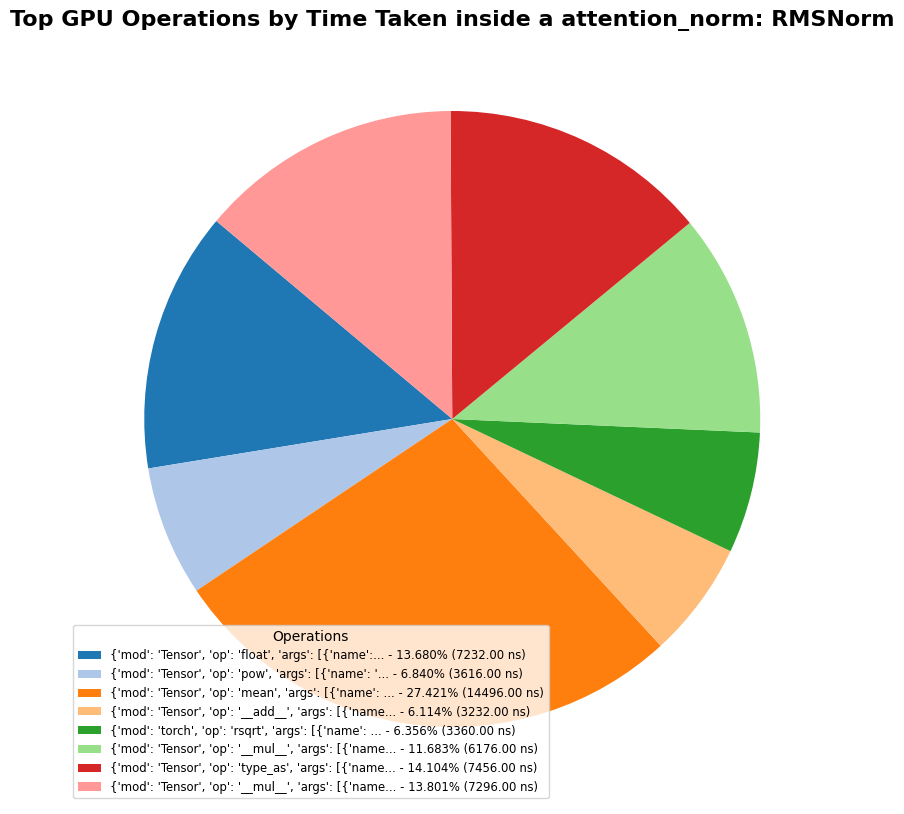

In [114]:
filter_and_plot_gpu_operations(df_nvtx_gpu_proj_trace, 'attention_norm: RMSNorm', 'attention: Attention', 1420)

### attention:Attention Analysis

Start Index: 2348
End Index: 2440
Selected Rows after filtering:


/var/folders/sg/b1qbnvkj7fjbgjw1kzc9drzw0000gn/T/ipykernel_38876/4093825718.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_selected = df_selected[~df_selected['Name'].str.contains('(/home|traceMarker)')]


,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,NumChild,RangeId,ParentId,RangeStack
2349,wq: ColumnParallelLinear,16684915911,47424,16430110151,255172472,PushPop,734,734,1,1419,1,35748,35747.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2355,wk: ColumnParallelLinear,16686852844,40384,16685318123,1594051,PushPop,734,734,1,1419,1,36253,35747.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2361,wv: ColumnParallelLinear,16687574286,36128,16686921494,711106,PushPop,734,734,1,1419,1,36274,35747.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2395,"aten::copy_, op_id = 152",16693308062,3808,16693277529,120639,PushPop,734,734,1,1419,0,36388,35747.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2396,"aten::copy_, op_id = 157",16693432991,3648,16693414678,46550,PushPop,734,734,1,1419,0,36395,35747.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2428,"aten::contiguous, op_id = 211",16727651776,7328,16727534258,222219,PushPop,734,734,1,1419,1,36549,35747.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2431,wo: RowParallelLinear,16728463683,37376,16728073606,1041864,PushPop,734,734,1,1419,1,36559,35747.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2438,"{'mod': 'Tensor', 'op': '__add__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096)...",16729407781,4256,16729338418,164840,PushPop,734,734,1,1419,1,36578,36577.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...


Unique Names: ['wq: ColumnParallelLinear' 'wk: ColumnParallelLinear'
 'wv: ColumnParallelLinear' 'aten::copy_, op_id = 152'
 'aten::copy_, op_id = 157' 'aten::contiguous, op_id = 211'
 'wo: RowParallelLinear'
 "{'mod': 'Tensor', 'op': '__add__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), 'dtype': 'float16'}, {'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), 'dtype': 'float16'}]}"]
Selected Rows after adding Time (%):


,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,NumChild,RangeId,ParentId,RangeStack,Time (%)
2349,wq: ColumnParallelLinear,16684915911,47424,16430110151,255172472,PushPop,734,734,1,1419,1,35748,35747.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,26.295245
2355,wk: ColumnParallelLinear,16686852844,40384,16685318123,1594051,PushPop,734,734,1,1419,1,36253,35747.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,22.391767
2361,wv: ColumnParallelLinear,16687574286,36128,16686921494,711106,PushPop,734,734,1,1419,1,36274,35747.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,20.031938
2395,"aten::copy_, op_id = 152",16693308062,3808,16693277529,120639,PushPop,734,734,1,1419,0,36388,35747.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,2.111427
2396,"aten::copy_, op_id = 157",16693432991,3648,16693414678,46550,PushPop,734,734,1,1419,0,36395,35747.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,2.022711
2428,"aten::contiguous, op_id = 211",16727651776,7328,16727534258,222219,PushPop,734,734,1,1419,1,36549,35747.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,4.063165
2431,wo: RowParallelLinear,16728463683,37376,16728073606,1041864,PushPop,734,734,1,1419,1,36559,35747.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,20.723918
2438,"{'mod': 'Tensor', 'op': '__add__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096)...",16729407781,4256,16729338418,164840,PushPop,734,734,1,1419,1,36578,36577.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,2.359830


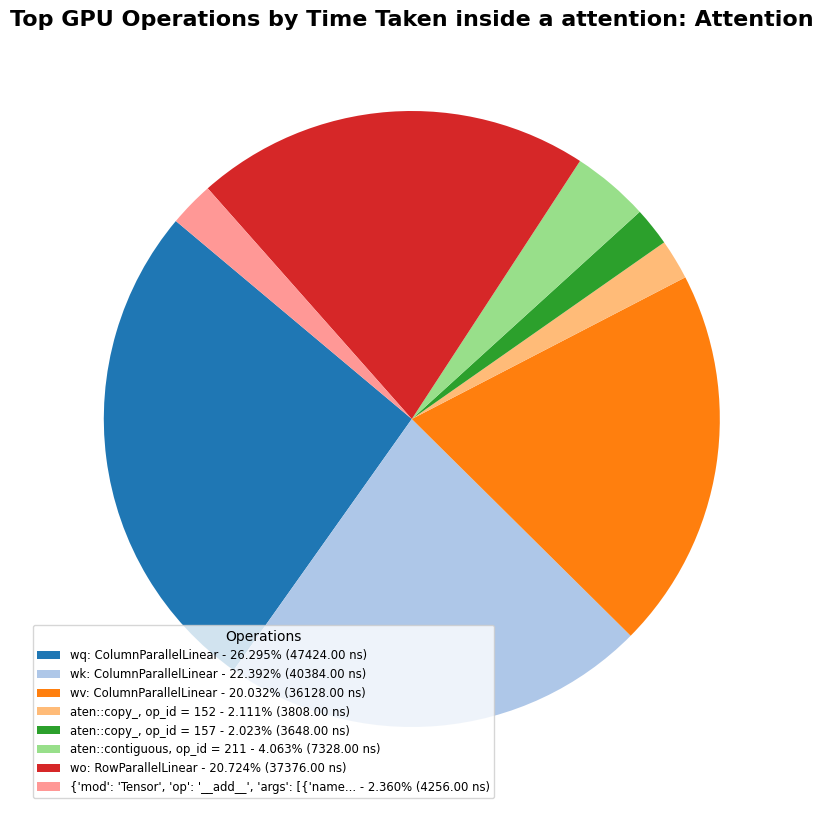

In [48]:
filter_and_plot_gpu_operations(df_nvtx_gpu_proj_trace, 'attention: Attention', 'ffn_norm: RMSNorm', 1419)

### ffn_norm: RMSNorm Analysis

Start Index: 2440
End Index: 2470
Selected Rows after filtering:


/var/folders/sg/b1qbnvkj7fjbgjw1kzc9drzw0000gn/T/ipykernel_38876/4093825718.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_selected = df_selected[~df_selected['Name'].str.contains('(/home|traceMarker)')]


,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,NumChild,RangeId,ParentId,RangeStack
2442,"{'mod': 'Tensor', 'op': 'float', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), ...",16729799334,7105,16729752566,91650,PushPop,734,734,1,1420,1,36584,36583.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2447,"{'mod': 'Tensor', 'op': 'pow', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), 'd...",16730134439,3616,16730083754,176959,PushPop,734,734,1,1420,1,36591,36590.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2450,"{'mod': 'Tensor', 'op': 'mean', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), '...",16730730345,16512,16730680481,159129,PushPop,734,734,1,1420,1,36598,36597.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2453,"{'mod': 'Tensor', 'op': '__add__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 1), '...",16731129162,3296,16731086119,166109,PushPop,734,734,1,1420,1,36603,36602.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2456,"{'mod': 'torch', 'op': 'rsqrt', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 1), 'dty...",16731540395,3360,16731502636,137980,PushPop,734,734,1,1420,1,36608,36607.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2459,"{'mod': 'Tensor', 'op': '__mul__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096)...",16731914156,6208,16731875384,167799,PushPop,734,734,1,1420,1,36613,36612.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2462,"{'mod': 'Tensor', 'op': 'type_as', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096)...",16732350926,8032,16732302462,285528,PushPop,734,734,1,1420,1,36618,36616.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2468,"{'mod': 'Tensor', 'op': '__mul__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096)...",16732864911,7232,16732830259,104709,PushPop,734,734,1,1420,1,36626,36625.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...


Unique Names: ["{'mod': 'Tensor', 'op': 'float', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), 'dtype': 'float16'}]}"
 "{'mod': 'Tensor', 'op': 'pow', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), 'dtype': 'float32'}]}"
 "{'mod': 'Tensor', 'op': 'mean', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), 'dtype': 'float32'}]}"
 "{'mod': 'Tensor', 'op': '__add__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 1), 'dtype': 'float32'}]}"
 "{'mod': 'torch', 'op': 'rsqrt', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 1), 'dtype': 'float32'}]}"
 "{'mod': 'Tensor', 'op': '__mul__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), 'dtype': 'float32'}, {'name': '', 'type': 'tensor', 'shape': (1, 8, 1), 'dtype': 'float32'}]}"
 "{'mod': 'Tensor', 'op': 'type_as', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), 'dtype': 'float32'}, {'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), 'dtype': 'float16'}

,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,NumChild,RangeId,ParentId,RangeStack,Time (%)
2442,"{'mod': 'Tensor', 'op': 'float', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), ...",16729799334,7105,16729752566,91650,PushPop,734,734,1,1420,1,36584,36583.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,12.833944
2447,"{'mod': 'Tensor', 'op': 'pow', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), 'd...",16730134439,3616,16730083754,176959,PushPop,734,734,1,1420,1,36591,36590.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,6.531674
2450,"{'mod': 'Tensor', 'op': 'mean', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), '...",16730730345,16512,16730680481,159129,PushPop,734,734,1,1420,1,36598,36597.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,29.826051
2453,"{'mod': 'Tensor', 'op': '__add__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 1), '...",16731129162,3296,16731086119,166109,PushPop,734,734,1,1420,1,36603,36602.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,5.953650
2456,"{'mod': 'torch', 'op': 'rsqrt', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 1), 'dty...",16731540395,3360,16731502636,137980,PushPop,734,734,1,1420,1,36608,36607.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,6.069255
2459,"{'mod': 'Tensor', 'op': '__mul__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096)...",16731914156,6208,16731875384,167799,PushPop,734,734,1,1420,1,36613,36612.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,11.213670
2462,"{'mod': 'Tensor', 'op': 'type_as', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096)...",16732350926,8032,16732302462,285528,PushPop,734,734,1,1420,1,36618,36616.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,14.508408
2468,"{'mod': 'Tensor', 'op': '__mul__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096)...",16732864911,7232,16732830259,104709,PushPop,734,734,1,1420,1,36626,36625.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,13.063348


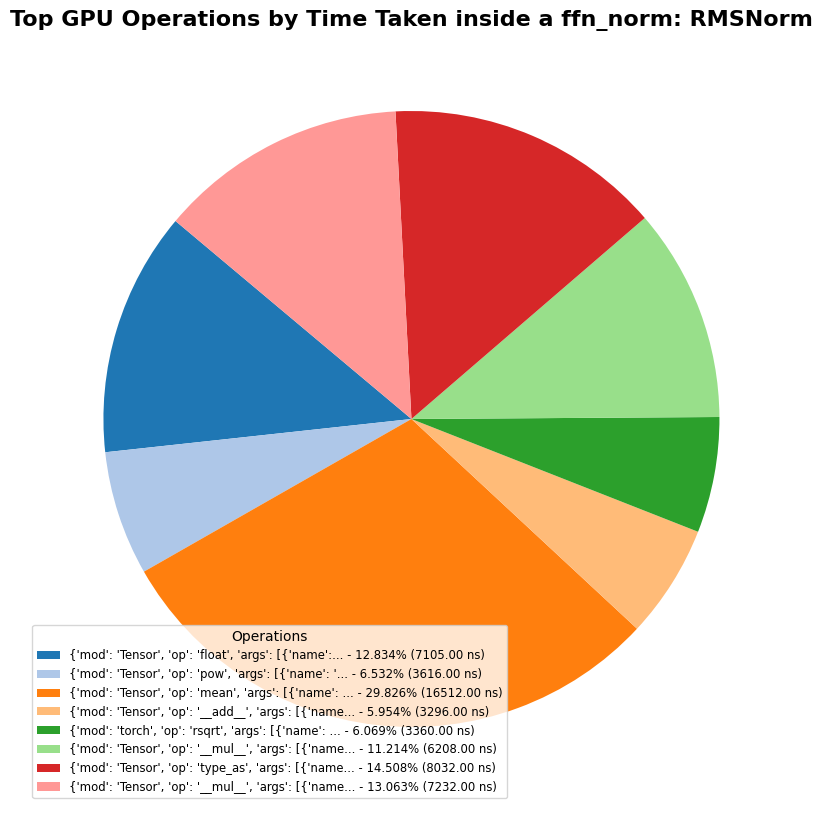

In [49]:
filter_and_plot_gpu_operations(df_nvtx_gpu_proj_trace, 'ffn_norm: RMSNorm', 'feed_forward: FeedForward', 1420)

### feed_forward: FeedForward Analysis

Start Index: 2470
End Index: 2498
Selected Rows after filtering:


/var/folders/sg/b1qbnvkj7fjbgjw1kzc9drzw0000gn/T/ipykernel_38876/4093825718.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_selected = df_selected[~df_selected['Name'].str.contains('(/home|traceMarker)')]


,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,NumChild,RangeId,ParentId,RangeStack
2471,w1: ColumnParallelLinear,16733731698,79936,16732962948,1030925,PushPop,734,734,1,1419,1,36631,36630.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2480,w3: ColumnParallelLinear,16739531714,77984,16738719156,865226,PushPop,734,734,1,1419,1,36666,36630.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2489,w2: RowParallelLinear,16740405765,81856,16740043449,833675,PushPop,734,734,1,1419,1,36690,36630.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...
2496,"{'mod': 'Tensor', 'op': '__add__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096)...",16741156007,4416,16741115433,187199,PushPop,734,734,1,1419,1,36709,36708.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...


Unique Names: ['w1: ColumnParallelLinear' 'w3: ColumnParallelLinear'
 'w2: RowParallelLinear'
 "{'mod': 'Tensor', 'op': '__add__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), 'dtype': 'float16'}, {'name': '', 'type': 'tensor', 'shape': (1, 8, 4096), 'dtype': 'float16'}]}"]
Selected Rows after adding Time (%):


,Name,Projected Start (ns),Projected Duration (ns),Orig Start (ns),Orig Duration (ns),Style,PID,TID,NumGPUOps,Lvl,NumChild,RangeId,ParentId,RangeStack,Time (%)
2471,w1: ColumnParallelLinear,16733731698,79936,16732962948,1030925,PushPop,734,734,1,1419,1,36631,36630.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,32.734897
2480,w3: ColumnParallelLinear,16739531714,77984,16738719156,865226,PushPop,734,734,1,1419,1,36666,36630.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,31.935526
2489,w2: RowParallelLinear,16740405765,81856,16740043449,833675,PushPop,734,734,1,1419,1,36690,36630.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,33.521164
2496,"{'mod': 'Tensor', 'op': '__add__', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8, 4096)...",16741156007,4416,16741115433,187199,PushPop,734,734,1,1419,1,36709,36708.0,:3877:3878:3879:3880:3881:3882:3883:3884:3887:3888:3889:3890:3891:3892:3893:3894:3895:3896:3899:...,1.808413


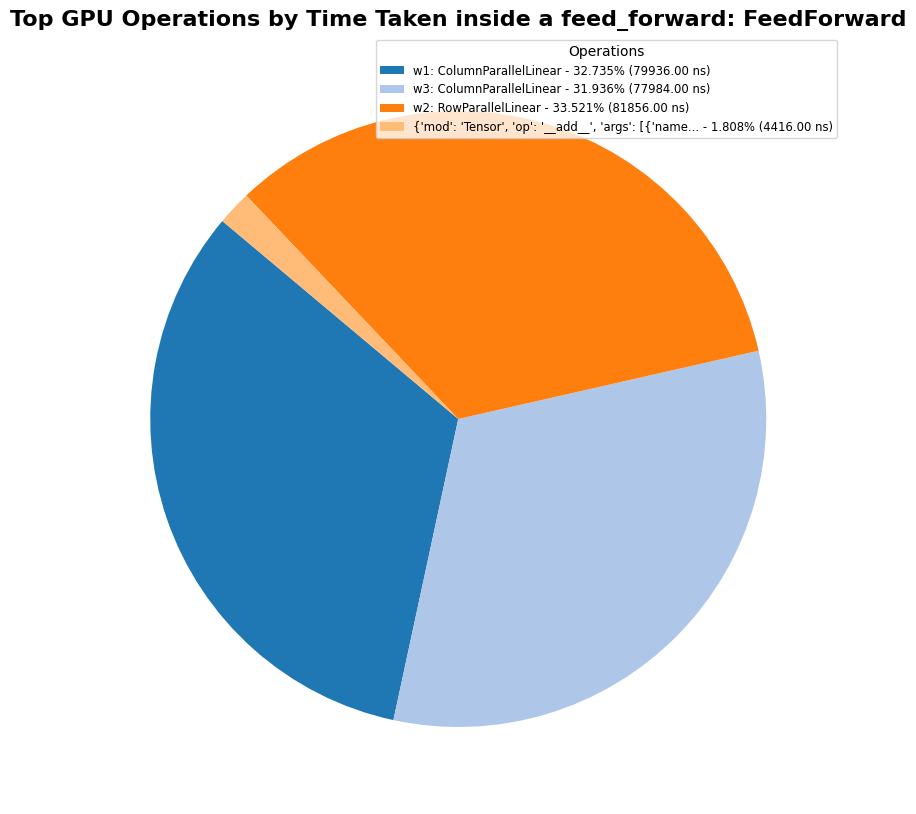

In [50]:
filter_and_plot_gpu_operations(df_nvtx_gpu_proj_trace, 'feed_forward: FeedForward', '1: TransformerBlock', 1419)

# NVTX Pushpop Summary

In [51]:
nvtx_pushpop_summary_csv_path = BASE_PATH + "nvtx_pushpop_summary.csv"
df_nvtx_pushpop_summary = pd.read_csv(nvtx_pushpop_summary_csv_path)

In [52]:
df_nvtx_pushpop_summary

,Time (%),Total Time (ns),Instances,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),Range
0,0.827504,1919259118,64,2.998842e+07,24201605.0,23376851,360867255,4.220670e+07,0: TransformerBlock
1,0.666536,1545919864,64,2.415500e+07,24028997.0,23517019,25339099,4.449319e+05,10: TransformerBlock
2,0.668203,1549786467,64,2.421541e+07,24191675.5,23374350,25838687,5.061615e+05,11: TransformerBlock
3,0.667049,1547110134,64,2.417360e+07,24050922.0,23386450,25236060,4.361598e+05,12: TransformerBlock
4,0.665781,1544170349,64,2.412766e+07,23995616.0,23221861,25221220,4.570644e+05,13: TransformerBlock
...,...,...,...,...,...,...,...,...,...
458972,0.005420,12571056,64,1.964228e+05,195669.0,168319,238949,9.966276e+03,"{'traceMarker': ['/home/llama/example_text_completion.py:74', '/root/miniconda3/envs/llama-profi..."
458973,0.004314,10004770,64,1.563245e+05,152274.0,143429,267578,1.641738e+04,"{'traceMarker': ['/home/llama/example_text_completion.py:74', '/root/miniconda3/envs/llama-profi..."
458974,0.004862,11277646,64,1.762132e+05,160294.0,143810,233678,2.798814e+04,"{'traceMarker': ['/home/llama/example_text_completion.py:74', '/root/miniconda3/envs/llama-profi..."
458975,0.004474,10376241,64,1.621288e+05,159254.0,152549,188059,8.818329e+03,"{'traceMarker': ['/home/llama/example_text_completion.py:74', '/root/miniconda3/envs/llama-profi..."


In [53]:
# Remove all "Range" that include "/home" or "traceMarker" and recalculate the time percentage
# Use regex to filter out the rows
time_percentage_col = 'Time (%)'
operation_col = 'Range'
df_nvtx_pushpop_summary = df_nvtx_pushpop_summary[~df_nvtx_pushpop_summary[operation_col].str.contains("(/home|traceMarker)")]

# Recalculate the time percentage
total_time = df_nvtx_pushpop_summary[time_percentage_col].sum()
df_nvtx_pushpop_summary[time_percentage_col] = df_nvtx_pushpop_summary[time_percentage_col] / total_time * 100

/var/folders/sg/b1qbnvkj7fjbgjw1kzc9drzw0000gn/T/ipykernel_38876/4199507355.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_nvtx_pushpop_summary = df_nvtx_pushpop_summary[~df_nvtx_pushpop_summary[operation_col].str.contains("(/home|traceMarker)")]
/var/folders/sg/b1qbnvkj7fjbgjw1kzc9drzw0000gn/T/ipykernel_38876/4199507355.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nvtx_pushpop_summary[time_percentage_col] = df_nvtx_pushpop_summary[time_percentage_col] / total_time * 100


In [54]:
# Filter out the rows where time percentage is less than threshold
threshold = 0.75
df_filtered = df_nvtx_pushpop_summary[df_nvtx_pushpop_summary[time_percentage_col] >= threshold]

# Table of Time (%), Avg (ns), and Range
df_filtered[['Time (%)', 'Avg (ns)', 'Range']].sort_values(by='Time (%)', ascending=False)

,Time (%),Avg (ns),Range
32,23.860570,7.926049e+08,Transformer
458123,13.116956,1.361630e+07,attention: Attention
458126,3.379868,3.508534e+06,feed_forward: FeedForward
458124,3.123350,3.242251e+06,attention_norm: RMSNorm
458127,3.073817,3.190832e+06,ffn_norm: RMSNorm
458136,1.047089,1.086949e+06,wq: ColumnParallelLinear
458131,0.933152,9.686755e+05,w1: ColumnParallelLinear
0,0.902771,2.998842e+07,0: TransformerBlock
458135,0.891356,9.252884e+05,wo: RowParallelLinear
458132,0.760470,7.894199e+05,w2: RowParallelLinear


<Figure size 1200x1000 with 0 Axes>

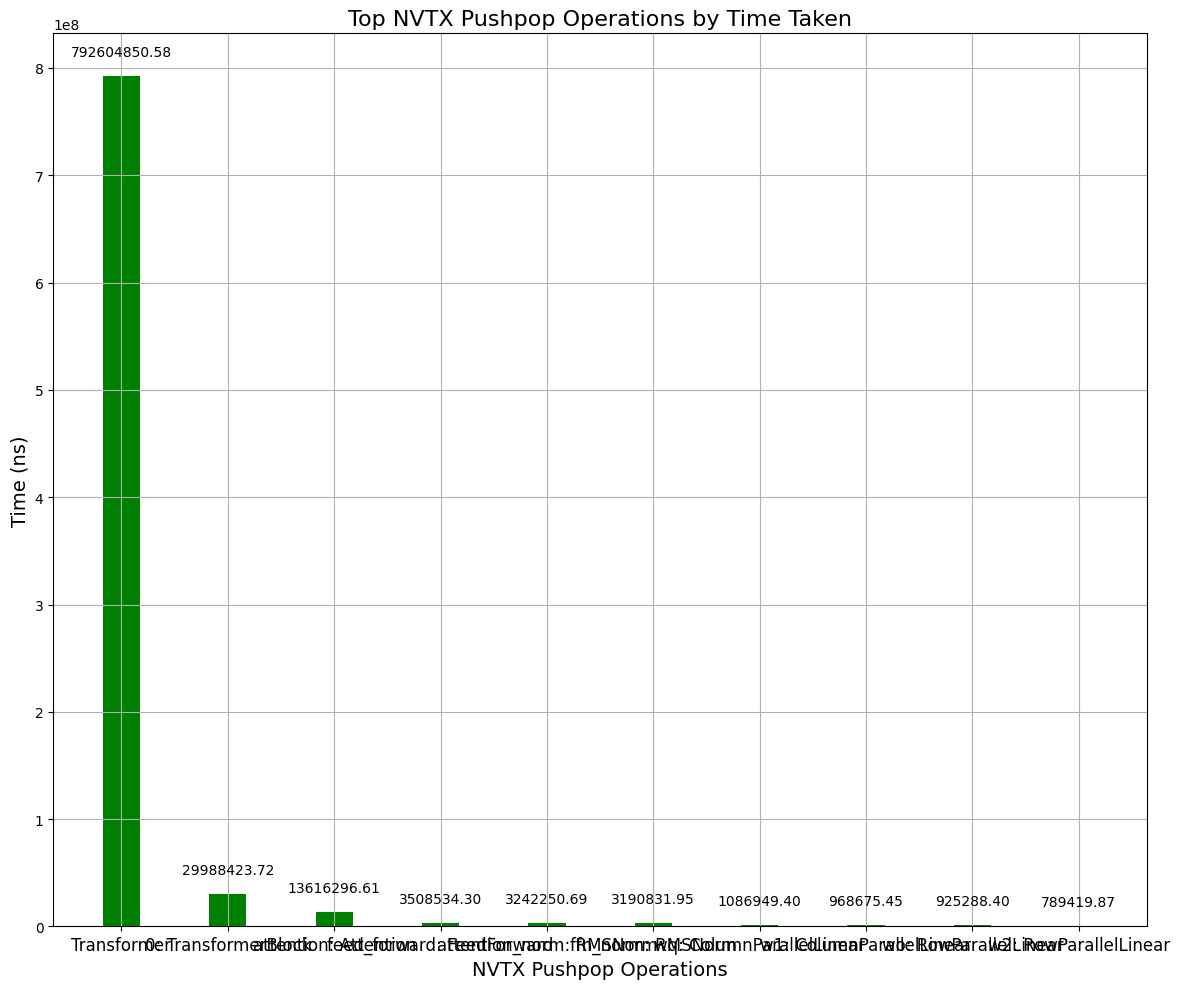

In [55]:

# Plot the top 10 NVTX pushpop operations by time taken ('Avg (ns)') in bar chart
# Use the filtered dataframe and Avg (ns) column
plot_time(df = df_filtered,
            title = "Top NVTX Pushpop Operations by Time Taken",
            limit = 10,
            time_col = 'Avg (ns)',
            name_col = 'Range',
            label_col = 'Avg (ns)',
            x_label = "NVTX Pushpop Operations",
            y_label = "Time (ns)",
            legend_label = "Avg Time (ns)",
            bar_color = 'g',
            figsize = (12, 10),
            legends = False,
            bar_width = 0.05,
            xlabel_rotation = 0)

In [56]:
other_items = plot_pie_chart(df = df_nvtx_pushpop_summary,
                title = "NVTX Push/Pop Time Summary",
                threshold = 0.75,
                time_percentage_col = 'Time (%)',
                legend_title = "NVTX Push/Pop Ranges",
                operation_col = "Range",
                # Color with brown color palette other than tab20
                colors = sns.color_palette("tab20", len(df_nvtx_pushpop_summary)),
                plt_title = "NVTX Push/Pop Time Summary",
                figsize = (10, 10))

other_items                

TypeError: plot_pie_chart() got an unexpected keyword argument 'time_percentage_col'

In [ ]:
df = df_nvtx_pushpop_summary.sort_values(by='Avg (ns)', ascending=False).head(50)
names = df['Range'].tolist()
names

['Transformer',
 "{'mod': 'torch.nn.functional', 'op': 'embedding', 'args': [{'name': '', 'type': 'tensor', 'shape': (1, 8), 'dtype': 'int64'}, {'name': '', 'type': 'tensor', 'shape': (32000, 4096), 'dtype': 'float16'}]}",
 "{'mod': 'torch', 'op': 'embedding', 'args': [{'name': '', 'type': 'tensor', 'shape': (32000, 4096), 'dtype': 'float16'}, {'name': '', 'type': 'tensor', 'shape': (1, 8), 'dtype': 'int64'}]}",
 'aten::embedding, op_id = 31',
 'aten::index_select, op_id = 34',
 'aten::linear, op_id = 77',
 'aten::matmul, op_id = 81',
 'aten::mm, op_id = 84',
 'cuBLAS:cublasCreate_v2',
 '_ReduceFromModelParallelRegion, seq = 61, op_id = 2026',
 'aten::multinomial, op_id = 7315',
 '0: TransformerBlock',
 'aten::rsqrt, op_id = 66',
 'aten::softmax, op_id = 191',
 'aten::_softmax, op_id = 192',
 '8: TransformerBlock',
 '31: TransformerBlock',
 '16: TransformerBlock',
 '26: TransformerBlock',
 '18: TransformerBlock',
 '24: TransformerBlock',
 '27: TransformerBlock',
 '5: TransformerBlock',

In [39]:
# Print "Avg (ns)" and "Range" columns
df_sample = df[['Range', 'Avg (ns)']]

# Add an "Index" column to the DataFrame
df_sample['Index'] = np.arange(1, len(df_sample) + 1)

# Reset the index of the DataFrame
df_sample = df_sample.reset_index(drop=True)

# Print in order of "Index", "Range", and "Avg (ns)"
df_sample = df_sample[['Index', 'Range', 'Avg (ns)']]
df_sample

/var/folders/sg/b1qbnvkj7fjbgjw1kzc9drzw0000gn/T/ipykernel_49108/2775229196.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['Index'] = np.arange(1, len(df_sample) + 1)


,Index,Range,Avg (ns)
0,1,Transformer,7.926049e+08
1,2,"{'mod': 'torch.nn.functional', 'op': 'embedding', 'args': [{'name': '', 'type': 'tensor', 'shape...",3.118878e+08
2,3,"{'mod': 'torch', 'op': 'embedding', 'args': [{'name': '', 'type': 'tensor', 'shape': (32000, 409...",3.113592e+08
3,4,"aten::embedding, op_id = 31",3.113217e+08
4,5,"aten::index_select, op_id = 34",3.112611e+08
5,6,"aten::linear, op_id = 77",2.543260e+08
6,7,"aten::matmul, op_id = 81",2.542898e+08
7,8,"aten::mm, op_id = 84",2.542345e+08
8,9,cuBLAS:cublasCreate_v2,1.934585e+08
9,10,"_ReduceFromModelParallelRegion, seq = 61, op_id = 2026",3.719302e+07
